## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.


##### Questions:
1)	Analyze the results of the experiment and identify the effect of the Treatment on product purchase and Net Incremental Revenue
2)	Build a model to select the best customers to target that maximizes the Incremental Response Rate and Net Incremental Revenue. 
##### Deliverables
3)	Score the ‘Test.csv’ using the model and select the best customers and share the customer ID’s as  csv file 
4)	Explain briefly the approach used in a separate document and also share the code that can be executed to reproduce results.


## Table of contents

- Data gathering
- Assessing
- Data Cleaning
- EDA
  - Univariate exploration
  - Bivariate exploration
  - Multivariate exploration
- Question 1: Hypothesis Testing
    - Invariant metric
    - Evaluation metric
- Question 2: Modeling of promotion strategy
  - Feature engineering
- Evaluation of promotion strategy
- Final conclusion
- References

In [1]:
# load in packages
from itertools import combinations
import os
import shutil
from typing import Dict, List, Tuple
import warnings

from matplotlib.cbook import silent_list
from matplotlib.transforms import BlendedGenericTransform

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from focalloss import FocalBinaryLoss

import xgboost as xgb
from xgboost import XGBClassifier, train
# for creating a feature tree
from xgboost import plot_tree
# for calculating feature importance
from xgboost import plot_importance
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, 
                             make_scorer, precision_score, f1_score)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

from optuna.samplers import TPESampler
import optuna.logging
import logging

from patsy import dmatrices
from sklearn.feature_selection import mutual_info_regression
from shutil import rmtree

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_defaults import Seafoam
%matplotlib inline
seafoam = Seafoam()
#suppress warnings
warnings.filterwarnings('ignore')
# sns.set_style("white")

In [2]:
# activate logging
logger = logging.getLogger(__name__)
logging.basicConfig(filename='log.log',
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    filemode='w',
                    level=logging.INFO,
                    datefmt='%Y-%m-%d %H:%M:%S')

In [3]:
# SEED = 108
RANDOM_STATE=88
N_FOLDS = 3
CV_RESULT_DIR_AUC = "./xgboost_cv_results/auc"
CV_RESULT_DIR_IRR = "xgboost_cv_results/irr_study_with_v2_not_scaled"

## Data Gathering

In [4]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [5]:
train_data.shape

(84534, 10)

## Assessing

In [6]:
# Inspect missing values and data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [7]:
# inspect descriptive statistics
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [8]:
# Inspect unique records
train_data.nunique()

ID           84534
Promotion        2
purchase         2
V1               4
V2           84518
V3              40
V4               2
V5               4
V6               4
V7               2
dtype: int64

In [9]:
# Get counts for unique values
cols = ['Promotion', 'purchase', 'V1', 'V3', 'V4', 'V5', 'V6', 'V7']
for col in cols:
    print(train_data[col].value_counts())

Promotion
Yes    42364
No     42170
Name: count, dtype: int64
purchase
0    83494
1     1040
Name: count, dtype: int64
V1
1    31631
2    31608
3    10670
0    10625
Name: count, dtype: int64
V3
 1.085939    2221
-1.165083    2208
-0.299306    2188
-1.424817    2171
 1.605406    2163
 1.518828    2156
-0.905350    2153
-1.338239    2140
-0.991928    2140
-1.684550    2139
 0.393317    2136
 0.047006    2133
 0.826206    2133
-1.597972    2131
-0.645617    2122
 0.306739    2118
-0.732194    2116
 0.566472    2115
 0.479895    2111
-0.212728    2111
-1.251661    2101
 0.739628    2101
-1.078506    2100
-0.385883    2100
 0.912784    2100
-0.039572    2099
 1.259095    2095
-0.126150    2087
 0.999361    2085
 1.345672    2084
-0.818772    2083
 0.653050    2080
-0.472461    2072
 0.220161    2072
-0.559039    2070
-1.511395    2064
 1.432250    2063
 1.172517    2060
 1.691984    2059
 0.133583    2054
Name: count, dtype: int64
V4
2    57450
1    27084
Name: count, dtype: int64
V5
3    

In [10]:
# check for duplicated lines
train_data.duplicated().sum()

0

### Summary of assessment

Overall data is very clean, there are no missing or duplicated values.
 
The following data cleaning steps are needed to prepare data for EDA.

1. Column Promotion is a boolean field that contains values 'Yes' or 'No'
2. Continues features V3 was normalized using standard scaler tecqnique, whilst V2 was not.
3. Drop unneeded variables like 'ID'
4. V1, V4, V5, V6, V7 are categorical values
5. Create a new response variable where customers who received promotions bought the product

## Data Cleaning

In [11]:
#  Make a copy of the data
train_data_clean = train_data.copy(deep=True)

##### 1. Convert 'Promotion' to a binary field to support EDA

In [12]:
# values before conversion
train_data_clean['Promotion'].value_counts()

Promotion
Yes    42364
No     42170
Name: count, dtype: int64

In [13]:
le = LabelEncoder()
train_data_clean['Promotion'] = le.fit_transform(train_data_clean['Promotion'])

# values after conversion
train_data_clean['Promotion'].value_counts()

Promotion
1    42364
0    42170
Name: count, dtype: int64

##### 2. Use standard scaler on V2 to compare with V3 more effectively.

In [14]:
# scaler = StandardScaler()
# train_data_clean['V2'] = scaler.fit_transform(train_data_clean[['V2']])
# train_data_clean['V2'].describe()

##### 3. Drop ID column

In [15]:
## Make ID the index the remove it
train_data_clean.drop('ID', axis=1, inplace=True)
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Promotion  84534 non-null  int64  
 1   purchase   84534 non-null  int64  
 2   V1         84534 non-null  int64  
 3   V2         84534 non-null  float64
 4   V3         84534 non-null  float64
 5   V4         84534 non-null  int64  
 6   V5         84534 non-null  int64  
 7   V6         84534 non-null  int64  
 8   V7         84534 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 5.8 MB


##### 4. Convert categorical columns


In [16]:
# train_data_clean = pd.get_dummies(train_data_clean, columns=['V1', 'V4', 'V5', 'V6', 'V7'], dtype='int8', drop_first=True)
# train_data_clean.head()

##### 5. Create new response variable of customers who received a promotion and bought the product

In [17]:
# train_data_clean['response'] = np.where((train_data_clean['purchase'] == 1) &
#                                         (train_data_clean['Promotion'] == 1), 1, 0)

In [18]:
# train_data_clean['response'].value_counts()

## Exploratory Data Analysis

In [19]:
# Split data into control and treatment groups
control_group = train_data_clean.query('Promotion == 0')
treatment_group = train_data_clean.query('Promotion == 1')

# drop promotion from treatment and control datasets as it's the split criteria
treatment_group = treatment_group.drop('Promotion', axis=1, errors='ignore')
control_group = control_group.drop('Promotion', axis=1, errors='ignore')
treatment_group.head()

,purchase,V1,V2,V3,V4,V5,V6,V7
4,0,3,28.044331,-0.385883,1,1,2,2
8,0,2,31.930423,0.393317,2,3,1,2
10,0,1,32.770916,-1.511395,2,1,4,1
12,0,1,36.957009,0.133583,2,3,1,1
14,0,3,36.911714,-0.905350,2,2,4,1


### Univariate Exploration

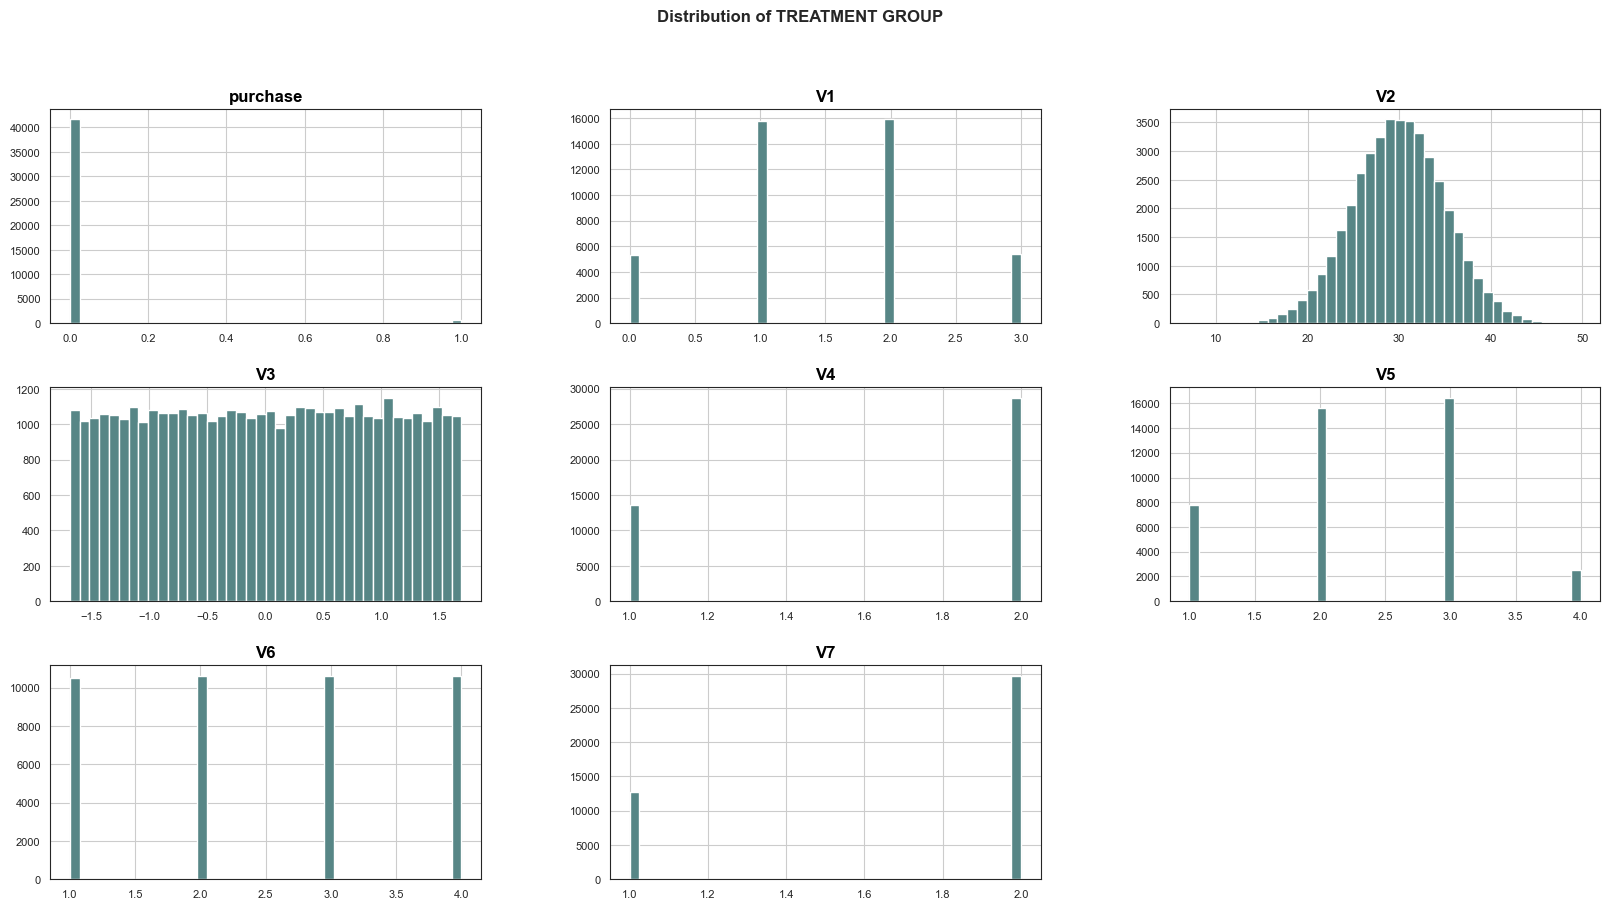

In [63]:
# get a general first idea of numeric feature distributions for the TREATMENT group
pd.plotting.hist_frame(treatment_group, figsize=(20,10), bins=40, color=seafoam.base_color_group1)
plt.suptitle("Distribution of TREATMENT GROUP")
plt.show()

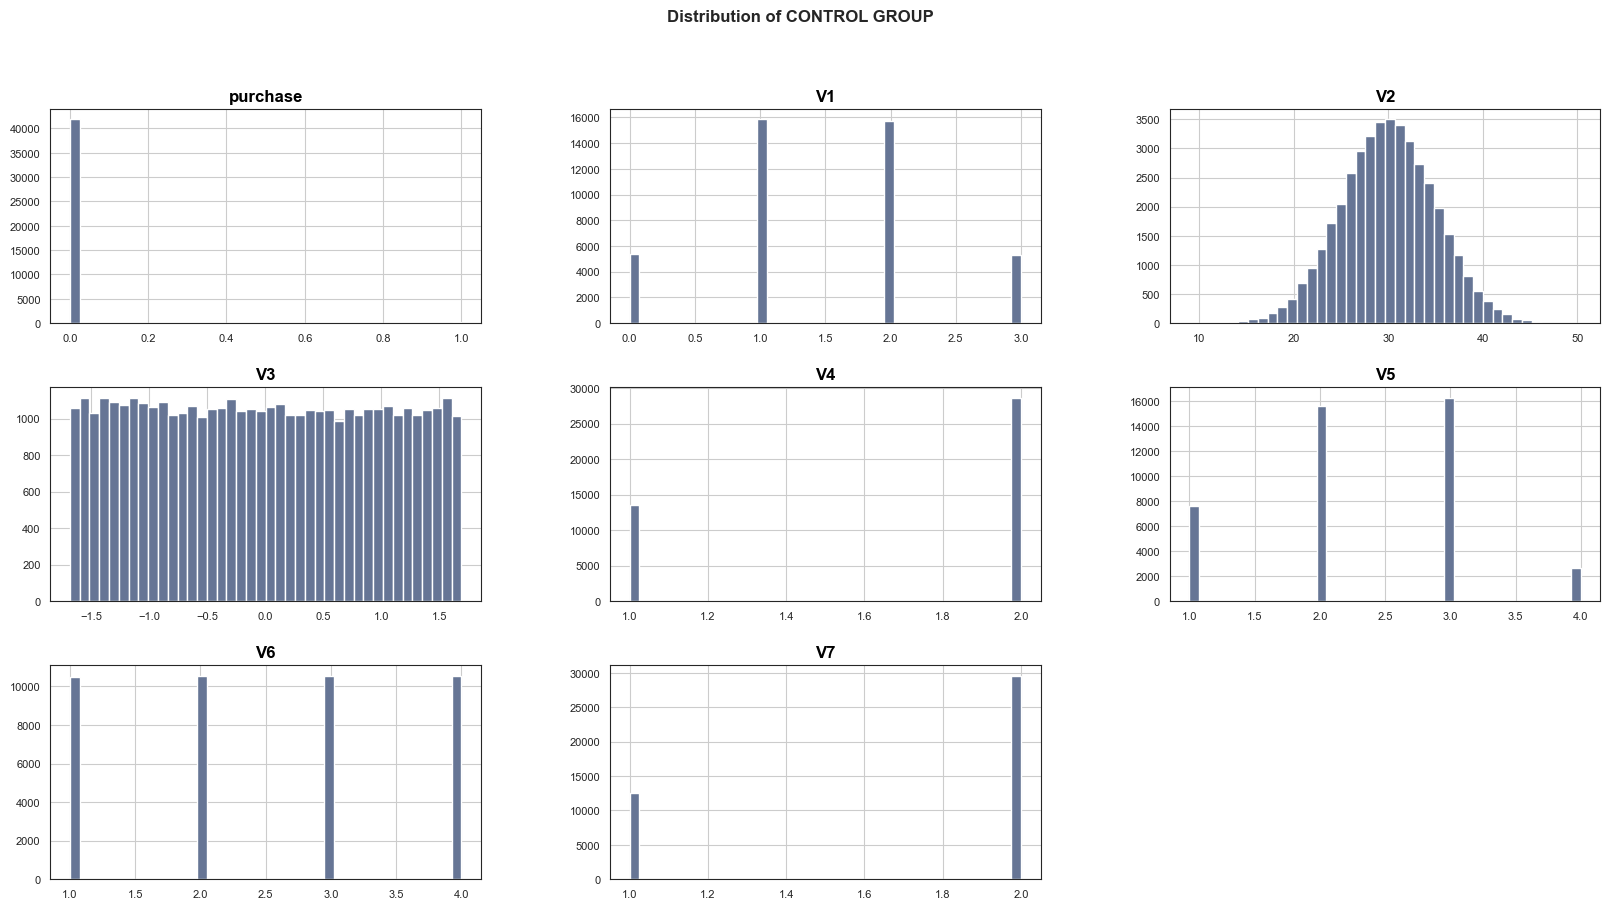

In [64]:
# get a general first idea of numeric feature distributions for the CONTROL group
pd.plotting.hist_frame(control_group, figsize=(20,10), bins=40, color=seafoam.base_color_group2)
plt.suptitle("Distribution of CONTROL GROUP")
plt.show()

> Observations: 
> 
> - By visual inspection, the distribution of features V1-V7 appears to be the same for control and treatment groups
> - V2 and V3 are continues variables. V2 have normal distribution, V3 have uniform distribution
> - The Rest of the fields appear to be categorical, however it's possible to tell if it's ordinal

In [65]:
def fd_optimal_bins(data: np.array) -> int:
    """ The Freedman-Diaconis rule for optimal bin selection
    Parameters: 
        data (np.array) - a one-dimensional array with data
    Returns:
        nbins (int) - number of bins
    """
    assert data.ndim == 1
    n = data.size
    
    p25, p75 = np.percentile(data, [25, 75])

    width = 2. * (p75 - p25)/n**(1./3)
    nbins = np.ceil((data.max() - data.min()) / width)
    nbins = max(1, nbins)
    
    return nbins

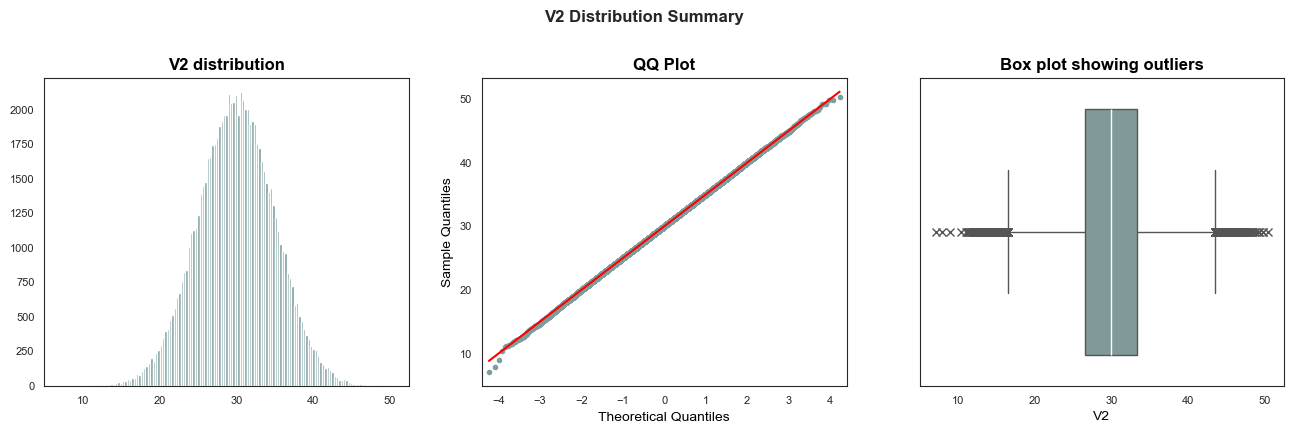

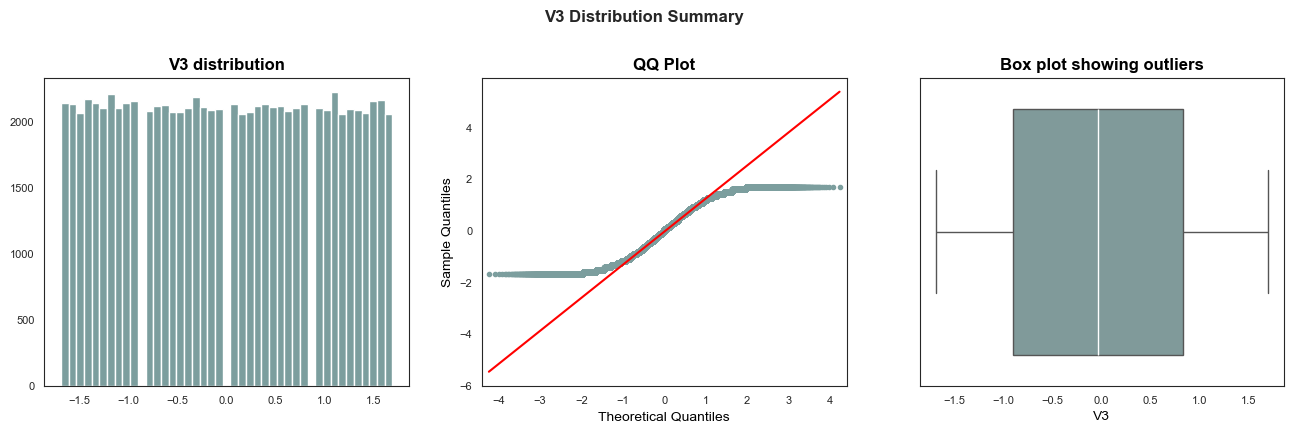

In [66]:
# 2 fields are continues numerical values, lets deeper investigate them
for col in ['V2', 'V3']:
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    bin_size = fd_optimal_bins(train_data_clean[col])
    # bins = np.arange(train_data_clean[col].min() - bin_size, train_data_clean[col].max() + bin_size, bin_size)
    plt.hist(x=train_data_clean[col], bins=int(bin_size), color=seafoam.base_color)
    plt.title('{} distribution'.format(col))
    
    ax = plt.subplot(1, 3, 2)
    sm.qqplot(data=train_data_clean[col],
                       line='q',
                       ax=ax,
                       marker='.',
                       markerfacecolor=seafoam.base_color,
                       markeredgecolor=seafoam.base_color,
              )
    plt.title('QQ Plot')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(data=train_data_clean, x=col, color=seafoam.base_color,
                flierprops={"marker": "x"},
                medianprops={"color": 'white'},
                )
    plt.title('Box plot showing outliers')
    
    plt.suptitle('{} Distribution Summary'.format(col), y=1.05)
    plt.show()

>Observations: 
> - V2 have some extreme outliers < 10 and > 50 

### Bivariate Exploration

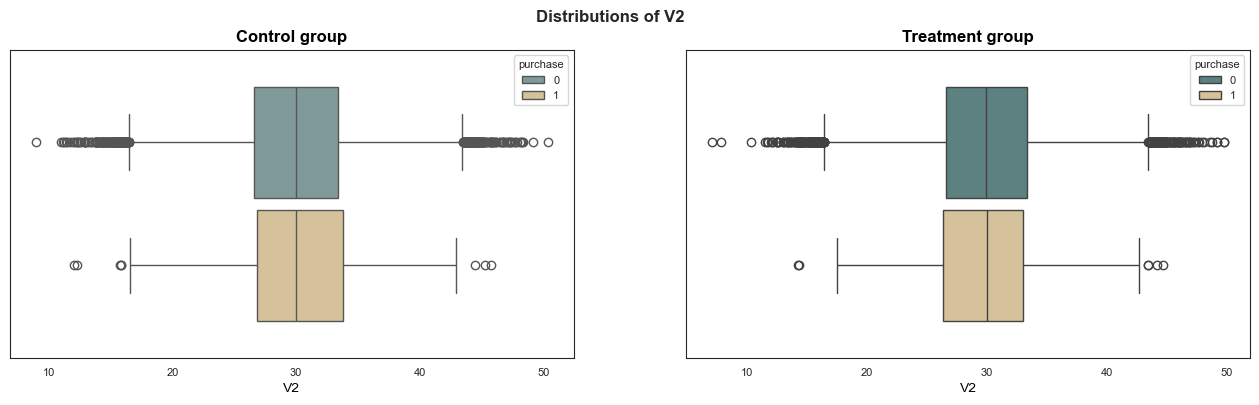

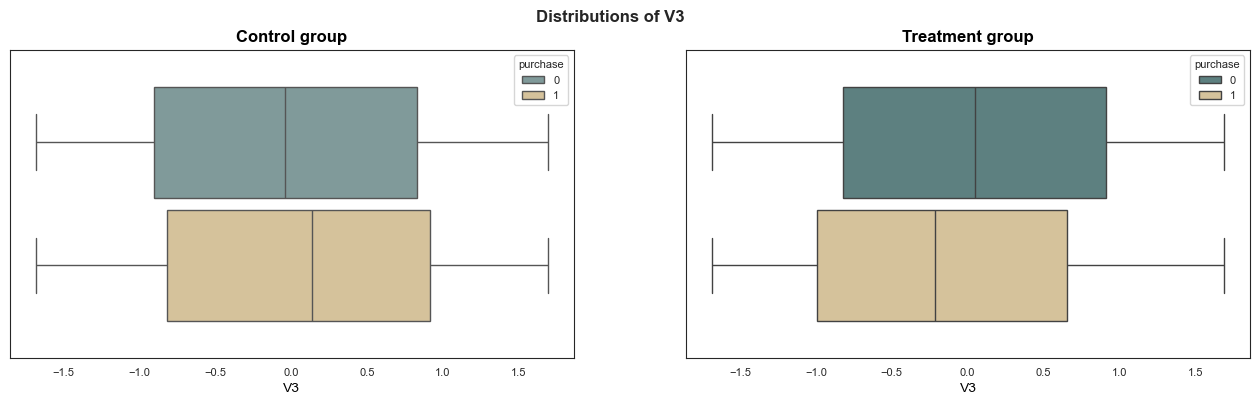

In [69]:
# Inspect differences in purchasing behavior between control and treatment groups
for col in ['V2', 'V3']:
    fig, ax = plt.subplots(ncols=2, figsize=(16, 4))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data=control_group,
                x=col,
                hue='purchase',
                dodge=True,
                gap=0.1,
                palette=(seafoam.base_color, seafoam.base_complimentary),
                )
    plt.title('Control group')
    plt.xlabel(col)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=treatment_group,
                x=col,
                hue='purchase',
                dodge=True,
                gap=0.1,
                palette=(seafoam.base_color_group1, seafoam.base_complimentary),
                )
    plt.title('Treatment group')
    
    plt.suptitle('Distributions of {}'.format(col))
    plt.show()

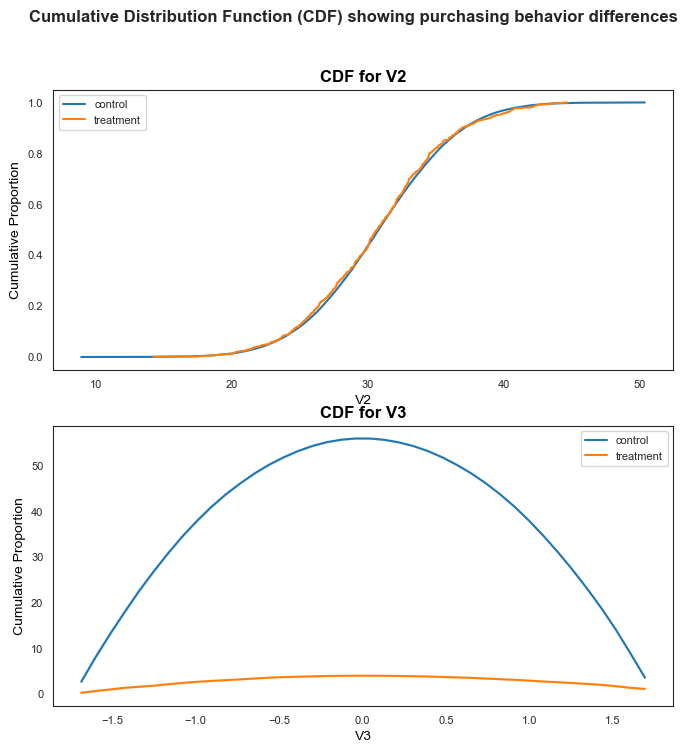

In [68]:
# PLOT cdf to plot the differences in distribution in purchasing behavior between the 2 groups
fig, ax = plt.subplots(nrows=2, figsize=(8, 8))
i = 1
for col in ['V2', 'V3']:
    plt.subplot(2, 1, i)
    cpur = control_group[control_group['purchase'] == 0][col]
    tpur = treatment_group[treatment_group['purchase'] == 1][col]
    c_sorted = np.sort(cpur)
    ccum = np.cumsum(c_sorted / np.sum(c_sorted))
    t_sorted = np.sort(tpur)
    tcum = np.cumsum(t_sorted / np.sum(t_sorted))
    sns.lineplot(x=c_sorted, y=ccum, label='control')
    sns.lineplot(x=t_sorted, y=tcum, label='treatment')
    plt.title('CDF for {}'.format(col))
    plt.xlabel(col)
    plt.ylabel('Cumulative Proportion')
    i += 1
    
plt.suptitle('Cumulative Distribution Function (CDF) showing purchasing behavior differences')
plt.show()

> There is a slight difference in purchasing behavior between treatment and control groups, the IQR of treatment are shifted slightly the left of the mean, however this difference is so small I think it's insignificant to further explore.

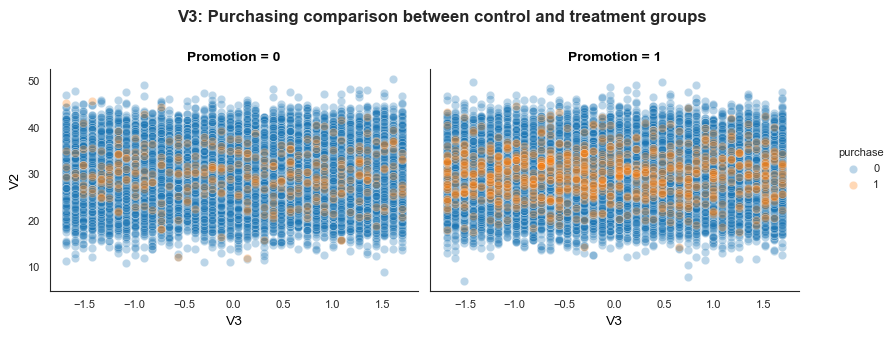

In [70]:
g = sns.FacetGrid(data=train_data_clean, hue='purchase', col='Promotion', margin_titles=True, height=3, aspect=1.4) 
g.map(sns.scatterplot, 'V3', 'V2', alpha=0.3, sizes=2)
g.add_legend()
g.set_titles('1', '2')
plt.suptitle('V3: Purchasing comparison between control and treatment groups', y=1.1)
plt.show()


<Figure size 2000x2000 with 0 Axes>

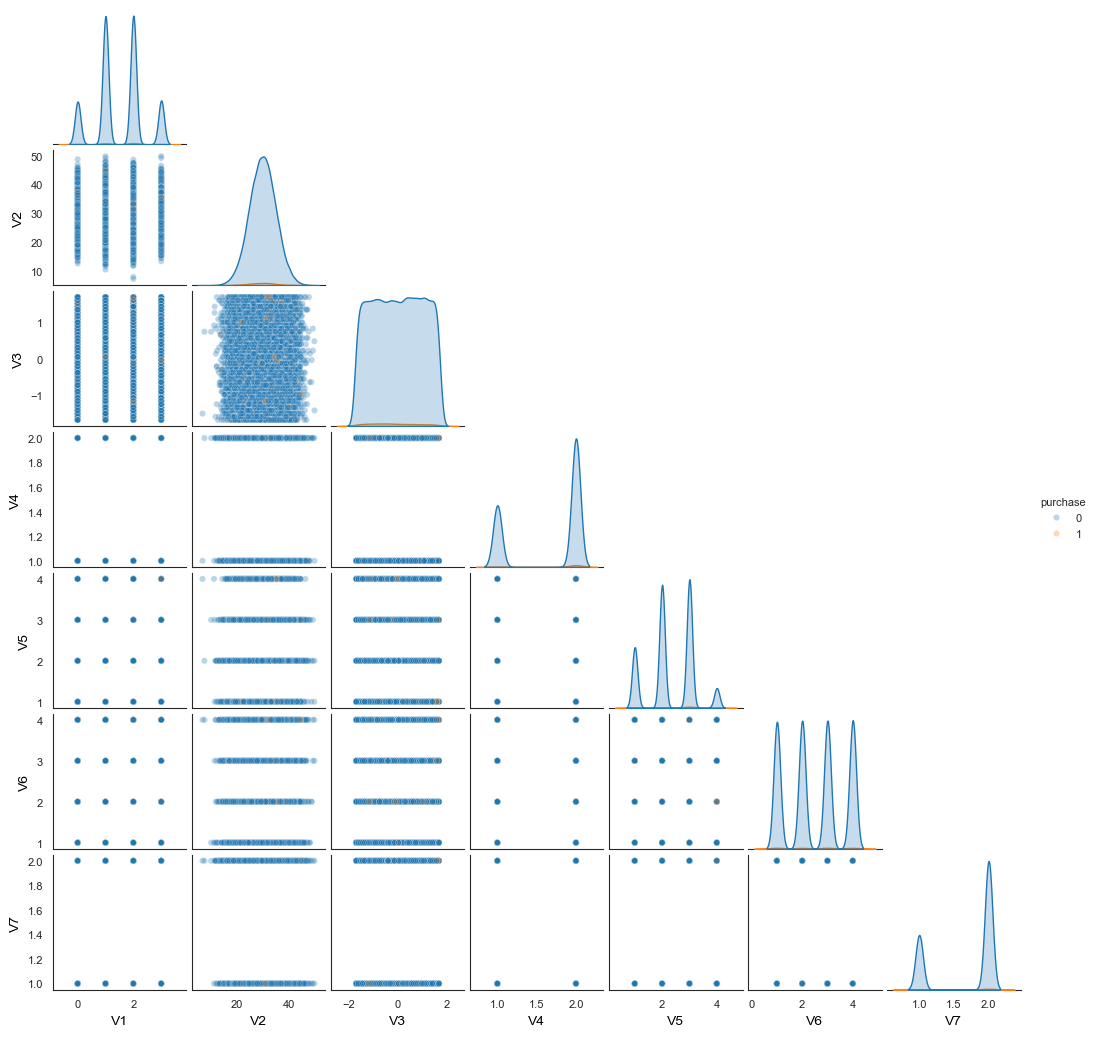

In [71]:
# Analyze the correlation between numeric variables
plt.figure(figsize=(20,20))
sns.pairplot(treatment_group, 
             diag_kind='auto',
             hue="purchase", 
             hue_order=[0, 1],
             corner=True, 
             height=1.5,
             plot_kws={"s": 20, "alpha": 0.3},
             )
plt.show()

>Observation:
In cases with high imbalance like in this project, this kind of plot relieves little information

#### Correlation analysis
- Make sure independent variables does not have too high correlations with each other

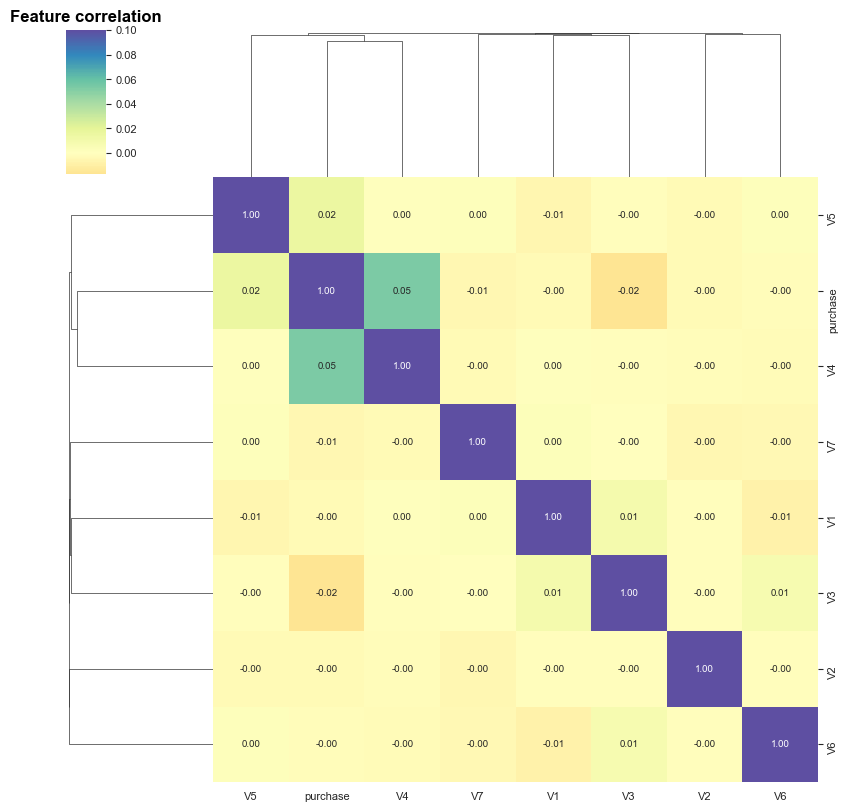

In [72]:
df_corr = treatment_group.corr(
    method='spearman',
    numeric_only=True,
    min_periods=1)

sns.clustermap(df_corr,
               cmap="Spectral",
               center=0,
               annot=True,
               fmt='.2f',
               vmax=0.1,
               annot_kws={"fontsize": 7},
               figsize=(8,8))

plt.title('Feature correlation')
plt.xticks(fontsize=10)
plt.show()

sns.set_style("white")

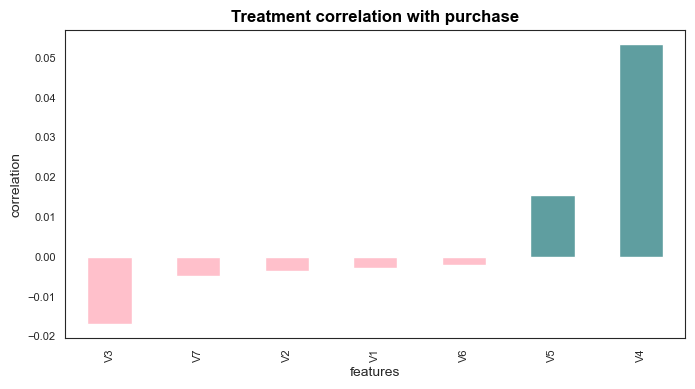

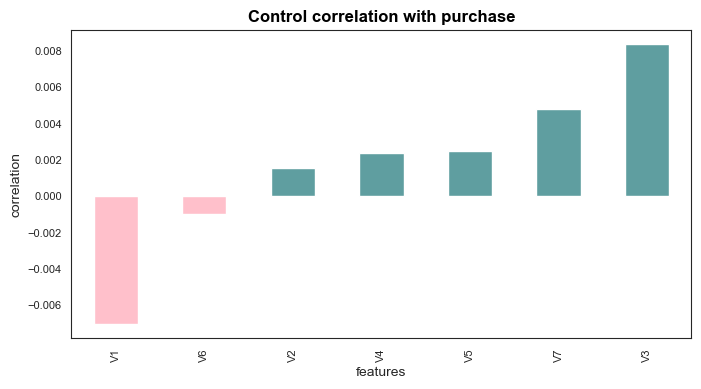

In [73]:
#  Get the strongest correlation of features with those who made a purchase
dfs = [treatment_group, control_group]
dfs_names = ['Treatment', 'Control']
i = 0
for df in dfs:
    cols = list(df.columns)
    cols.remove('purchase')
    
    corr_matrix = df[cols].corrwith(df["purchase"],
                                    method='spearman').sort_values()
    
    # Plot feature correlations to no_show
    palette = sns.color_palette("viridis_r", 15)
    pos = 'cadetblue'
    neg = 'pink'
    corr_matrix.plot(
        kind='bar',
        color=np.vectorize({True: pos, False: neg}.get)(corr_matrix > 0))
    
    plt.xticks(rotation='vertical')
    plt.ylabel('correlation')
    plt.xlabel('features')
    plt.title('{} correlation with purchase'.format(dfs_names[i]))
    i =+ 1
    plt.show()
    

### Multivariate Exploration

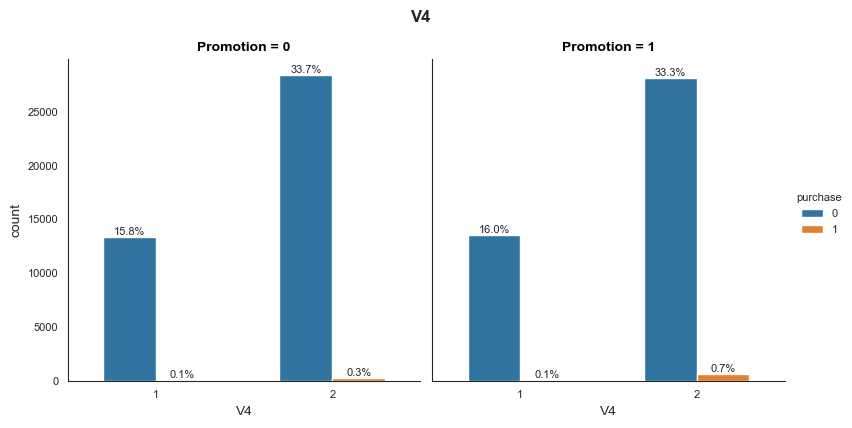

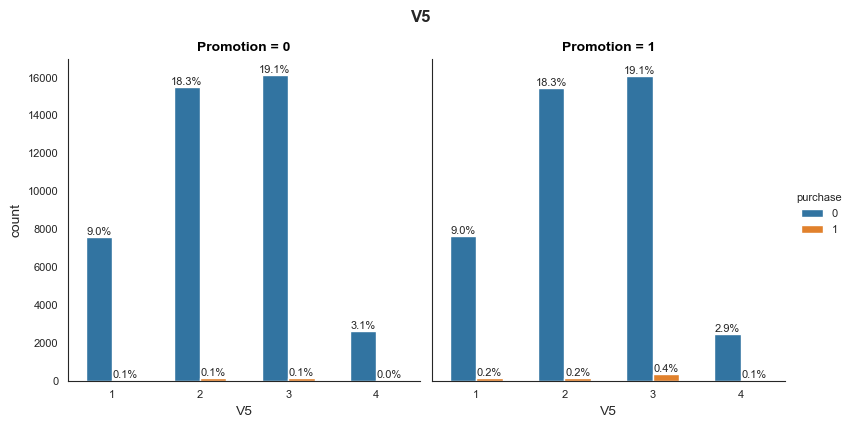

In [74]:
cols_of_interest = ['V4', 'V5']
for col in cols_of_interest:
    g = sns.catplot(data=train_data_clean, x=col, col='Promotion', hue='purchase', kind='count',
                height=4, aspect=1, width=0.6) 
    # g.despine(left=True)
    plt.suptitle(col, y=1.05)
    
    # iterate through each Facet (axes)
    for ax in g.axes.ravel():
        # iterate through the containers (bars)        
        for bars in ax.containers:
            labels = [f"{x/train_data_clean.shape[0]:.1%}" for x in bars.datavalues]
            ax.bar_label(bars, labels)
    
    plt.show()

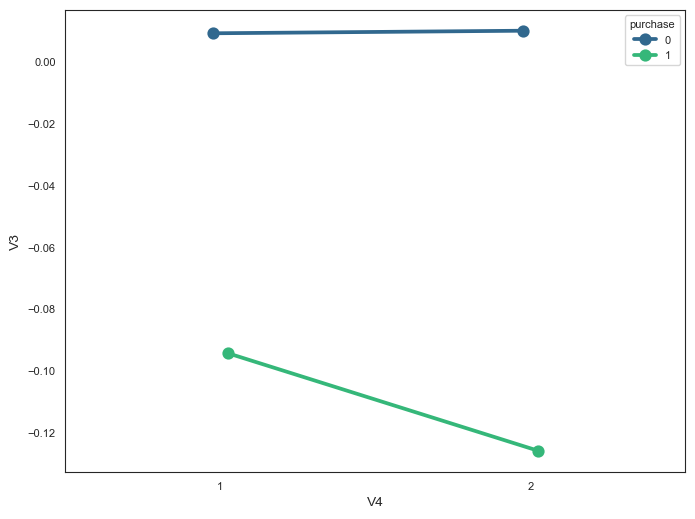

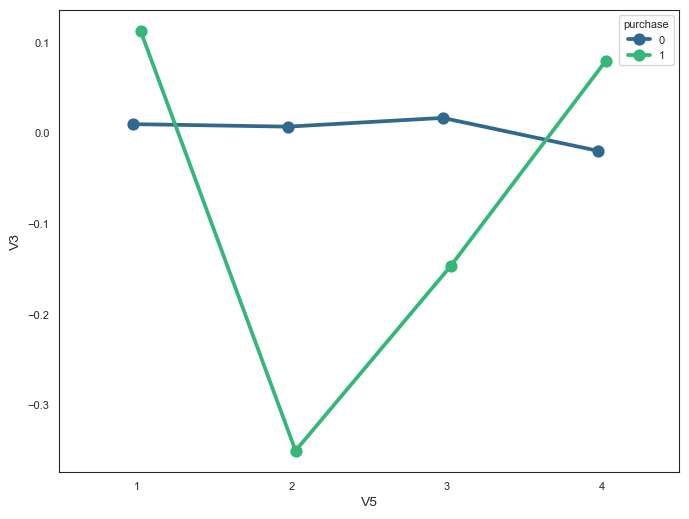

In [289]:
for col in ['V4', 'V5']:
    plt.figure(figsize = [8,6])
    sns.pointplot(data = treatment_group, x=col, y='V3', hue = 'purchase',  palette='viridis', 
                       errorbar=None,
                       dodge=True)
    plt.show()

## Hypothesis test for Invariant Metric

Make sure the control and treatment groups are the same.
The number of customers that were offered promotions should be the same as those customers that did not receive the promotion.

In this case, we want to do a two-sided hypothesis test on the proportion of promotions assigned to one of our conditions.

Hypothesis to test:

### $H_0: P_{no promotions} = 0.5$
### $H_a: P_{no promotions} \neq 0.5$

In [ ]:
total_observations = train_data_clean.shape[0]
total_observations

In [ ]:
# total control group without promotions
c_obs = control_group.shape[0]
c_obs

In [ ]:
control_proportion = (control_group.shape[0] + 0.5)/total_observations
control_proportion

In [ ]:
# total treatment group with promotions
t_obs = treatment_group.shape[0]
t_obs

In [ ]:
# Now calculate the sample standard deviation under the null
# As we don't know population std, we calculate sample std but call it standard error
# Null hypothesis is 50%, thus 0.5
p = 0.5
standard_error = np.sqrt((p*(1-p)/total_observations))
standard_error

In [ ]:
# formula for z score is sample mean - null mean / se
z = (control_proportion - p) / standard_error
z

In [ ]:
# calculate the area under a normal curve (on calculator it is invnorm -999, -0.638, 0, 1)
p_value = stats.norm.cdf(z, 0, 1)*2
p_value

In [ ]:
# TODO
# feature distributions should be the same
cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
for col in cols:
    diff = treatment_group[col].std() - control_group[col].std()
    

### Conclusion

Even though there's a few hundred more customers received promotions in the treatment group than the control group, the difference between groups isn't statistically significant. We should feel fine about moving on to test the evaluation metrics.

Since P value is more than .05, we fail to reject the null hypothesis. it means that the number of customers in both groups is similar.

# Hypothesis test for IRR
#### Did the promotion increase sales?

Analyze the results of the experiment and identify the effect of the Treatment on product purchase and Net Incremental Revenue

$$H_0 = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} <= 0$$
$$H_1 = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} > 0$$

In [ ]:
control_ratio = control_group.purchase.sum() / control_group.shape[0]
control_ratio

In [ ]:
treatment_ratio = treatment_group.purchase.sum() / treatment_group.shape[0]
treatment_ratio

In [ ]:
IRR = treatment_ratio - control_ratio
IRR

In [ ]:
control_group.purchase.sum()

In [ ]:
# calculate the total purchase rate
combined_download_ratio = train_data_clean.purchase.sum() / train_data_clean.shape[0]
combined_download_ratio

**Simulation Approach**

In [ ]:
# bootstrap download rate
nr_trials = 10_000

irr_sample_distribution = []
for _ in range(nr_trials):
    boot_sample = train_data_clean.sample(train_data_clean.shape[0], replace=True)
    boot_control_group = boot_sample.query('Promotion == 0')
    boot_treatment_group = boot_sample.query('Promotion == 1')
    boot_control_ratio =   boot_control_group.purchase.sum() / control_group.shape[0]
    boot_treatment_ratio = boot_treatment_group.purchase.sum() / treatment_group.shape[0]
    irr = boot_treatment_ratio - boot_control_ratio
    irr_sample_distribution.append(irr)
    
irr_sample_distribution = np.array(irr_sample_distribution)
p_diff_mean = irr_sample_distribution.mean()
p_diff_std = irr_sample_distribution.std()
p_diff_std, p_diff_mean

In [ ]:
# Simulate the null when using sample distribution
null_vals = np.random.normal(0, irr_sample_distribution.std(), irr_sample_distribution.size)

plt.hist(irr_sample_distribution, label='sample distribution')
plt.hist(null_vals, alpha=0.5, label='$H_0$ simulation')
plt.axvline(IRR, color='r', label='actual IRR')
plt.xlabel('IRR')
plt.ylabel('#purchase rate')
plt.title('Bootstrap distribution')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.9))
plt.show()

In [ ]:
# probability to observe again the population proportion using nulls in a 2 sided z test
p_value = (null_vals > irr).mean()
p_value

**Analytical Approach**

In [ ]:
se = np.sqrt((combined_download_ratio * (1-combined_download_ratio)/t_obs) + (combined_download_ratio * (1-combined_download_ratio)/c_obs))
se

In [ ]:
z = (treatment_ratio - control_ratio) / se
z

In [ ]:
p_value = round(1 - stats.norm.cdf(z, 0, 1),4)
p_value

### Conclusion of IRR

Since P is less than 0.5, we reject the null hypothesis. The difference of 0.9% in IRR is significant and could not have come from the null. Promotions have a positive effect on sales.

# Hypothesis test for NIR (Net Incremental Revenue)
#### How much is made (or lost) by sending out the promotion?

$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$


The experiment did not generate extra revenue
$$H_0 = NIR <= 0 $$ 
$$H_1 = NIR > 0 $$



In [ ]:
# Actual observation from the supplied experiment data
def nrr(control, treatment):
    nir = ((10 * treatment.purchase.sum()) -
           (0.15 * len(treatment)) -
           (10 * control.purchase.sum()))
    return nir

In [ ]:
NIR = nrr(control_group, treatment_group)

In [ ]:
# bootstrap NIR
nr_trials = 10_000
nr_samples = 20_000

nir_sample_distribution = []
for _ in range(nr_trials):
    boot_sample = train_data_clean.sample(train_data_clean.shape[0], replace=True)
    boot_control_group = boot_sample.query('Promotion == 0') 
    boot_treatment_group = boot_sample.query('Promotion == 1') 
    boot_nir = nrr(boot_control_group, boot_treatment_group)
    nir_sample_distribution.append(boot_nir)
    
nir_sample_distribution = np.array(nir_sample_distribution)
nir_mean = nir_sample_distribution.mean()
nir_std = nir_sample_distribution.std()
nir_std, nir_mean


In [ ]:
# Simulate the null when using sample distribution
null_vals = np.random.normal(0, nir_sample_distribution.std(), nir_sample_distribution.size)

plt.hist(nir_sample_distribution, label='sample distribution')
plt.hist(null_vals, alpha=0.5, label='$H_0$ simulation')
plt.axvline(NIR, color='r', label='actual NIR')
plt.xlabel('NIR')
plt.ylabel('Net Incremental Revenue')
plt.title('Bootstrap distribution')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.9))
plt.show()

In [ ]:
# probability to observe again the population proportion using nulls in a 2 sided z test
p_value = (null_vals > NIR).mean()
p_value

### Conclusion of NIR

Since p-value is above our corrected significance level of 0.025, we fail to reject the NULL hypothesis. 
The incremental revenue between no promotion and promotion groups from the experiment sample is not statistically significant.
There is no evidence that promotions generate more revenue.

# Question 2: Modeling of promotion strategy

### Model preprocessing

In [292]:
df_ml = treatment_group.copy(deep=True)

In [293]:
cat_cols = ['V1', 'V4', 'V5', 'V6', 'V7']
df_ml[cat_cols] = df_ml[cat_cols].astype("category")

In [294]:
# Use standard scaler on V2 to compare with V3 more effectively.
scaler = StandardScaler()
df_ml['V2'] = scaler.fit_transform(df_ml[['V2']])
df_ml.describe()

,purchase,V2,V3
count,42364.000000,4.236400e+04,42364.000000
mean,0.017019,1.998422e-16,0.007446
std,0.129344,1.000012e+00,0.998020
min,0.000000,-4.551071e+00,-1.684550
25%,0.000000,-6.765451e-01,-0.818772
50%,0.000000,3.759294e-03,0.047006
75%,0.000000,6.691248e-01,0.826206
max,1.000000,3.951404e+00,1.691984


In [ ]:
##### 4. Convert categorical columns

# df_ml = pd.get_dummies(df_ml, columns=['V1', 'V4', 'V5', 'V6', 'V7'], dtype='int8', drop_first=True)
# df_ml.head()

In [ ]:
# stats_cols = list(df_ml.columns)
# stats_cols.remove('purchase')
# 
# df_ml['intercept'] = 1
# lm = sm.Logit(df_ml['purchase'], df_ml[stats_cols])
# results = lm.fit(cov_type="hc1")
# results.summary()

### Mutual Information (MI) - Feature Importance

Mutual Information (MI) is a way to show how every feature interact with the target variable in this case 'purchase'. To interact means how a particular feature changes the target variable. Note: Mutual Information only works with numerical data

A higher value of MI means a closer connection between the feature and the target indicating feature importance for training the model. However, the lower the MI score like 0 indicates a weak connection between the feature and the target.

In [ ]:
# display Mutual Information scores of the features

# def get_mi_score(X, y):
#     """
#     Calculate mutual information to show feature importance.
# 
#     Estimated mutual information between each feature and the target
# 
#     Args:
#         X (array-like or sparse matrix) - Independent features
#         y (array-like) - Dependent feature to be predicted
#     Returns:
#         mi (ndarray) - estimated mutual information
#     """
# 
#     mi = mutual_info_regression(X, y, random_state=10)
#     mi = pd.Series(mi, index=X.columns).sort_values(ascending=False)
#     return mi
# 
# mi_score = get_mi_score(df_ml[stats_cols], df_ml['purchase'])
# 
# # Show most important features
# topn = 10
# plt.figure(figsize=(6, 8))
# ax = sns.barplot(y=mi_score.index[:topn], x=mi_score[:topn])
# plt.xlabel('MI score')
# plt.ylabel('Features')
# ax.set_title('Mutual Information (MI) scores showing feature importance')
# plt.show()

## Test for multicollinearity using Variance Inflation Factor (VIF)

Multicollinearity means, there are linear relationships or correlation between independent variables, which should not be the case for linear regression to be effective.

Typically, a variable with VIF greater than 5 indicates Multicollinearity.

In [ ]:

# # gather features
# treatment_group.drop(['intercept'], inplace=True, axis=1, errors='ignore')
# vip_features = " + ".join(treatment_group[cols])
# vip_features

In [ ]:
# sm_y, sm_X = dmatrices('purchase ~' + vip_features,
#                        treatment_group,
#                        return_type='dataframe')
# vif = pd.DataFrame()
# vif['VIF Factor'] = \
#     [variance_inflation_factor(sm_X.values, i) for i in range(sm_X.shape[1])]
# vif['features'] = sm_X.columns
# vif

# Clustering

In [295]:
df_ml.head()

,purchase,V1,V2,V3,V4,V5,V6,V7
4,0,3,-0.383332,-0.385883,1,1,2,2
8,0,2,0.390114,0.393317,2,3,1,2
10,0,1,0.557397,-1.511395,2,1,4,1
12,0,1,1.390553,0.133583,2,3,1,1
14,0,3,1.381538,-0.905350,2,2,4,1


In [296]:
# Divide dataset into those who received a promotion and those who did not
X_no_promotion = train_data_clean.query('Promotion == 0')
X_promotion = train_data_clean.query('Promotion == 1')

X_no_promotion = X_no_promotion[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']].copy(deep=True)
X_promotion = X_promotion[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']].copy(deep=True)
X_no_promotion.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42170 entries, 0 to 84533
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      42170 non-null  int64  
 1   V2      42170 non-null  float64
 2   V3      42170 non-null  float64
 3   V4      42170 non-null  int64  
 4   V5      42170 non-null  int64  
 5   V6      42170 non-null  int64  
 6   V7      42170 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 2.6 MB


In [301]:
def scree_plot(pca, annotate=True, cumulative=True):
    """  Investigate the variance accounted for by each principal component """
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    if cumulative:
        ax.plot(ind, cumvals)

    if annotate:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i] * 100)[:4])), (ind[i] + 0.2, vals[i]), va="bottom", ha="center",
                        fontsize=12)

        ax.xaxis.set_tick_params(width=0)
        ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.show()

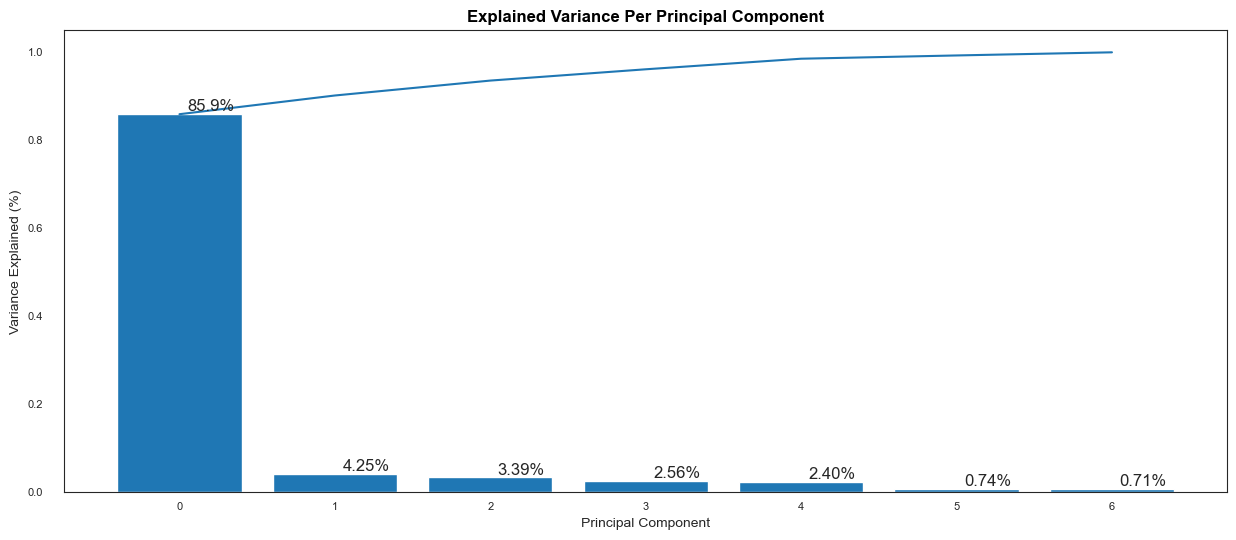

In [334]:
# do PCA with all features
from sklearn.decomposition import PCA
pca = PCA()
promotion_pca = pca.fit_transform(X_promotion)

# Investigate the variance accounted for by each principal component.
scree_plot(pca, annotate=True, cumulative=True)

In [360]:
# pca = PCA(4)
promotion_pca = pca.fit_transform(X_promotion)
promotion_pca.shape

(42364, 7)

In [336]:
def summarize_pca_results(df, pca):
    """Enhance pca data with index, column headings and explained variance"""

    # Dimension indexing
    dimensions = ['PCA {}'.format(i) for i in range(1, len(pca.components_) + 1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis=1)

In [361]:
pca_results = summarize_pca_results(X_promotion, pca)
pca_results

,Explained Variance,V1,V2,V3,V4,V5,V6,V7
PCA 1,0.8594,-0.0004,1.0000,-0.0005,-0.0002,-0.0006,-0.0006,-0.0004
PCA 2,0.0425,-0.0146,0.0006,0.0343,-0.0013,0.0032,0.9993,-0.0020
PCA 3,0.0339,0.0348,0.0005,0.9988,-0.0003,-0.0064,-0.0338,-0.0001
PCA 4,0.0257,0.9965,0.0003,-0.0346,0.0013,-0.0748,0.0160,0.0016
PCA 5,0.0240,0.0750,0.0007,0.0037,0.0006,0.9972,-0.0022,0.0019
PCA 6,0.0074,-0.0012,0.0001,0.0004,0.9969,-0.0003,0.0011,-0.0786
PCA 7,0.0071,-0.0019,0.0005,0.0002,0.0786,-0.0018,0.0021,0.9969


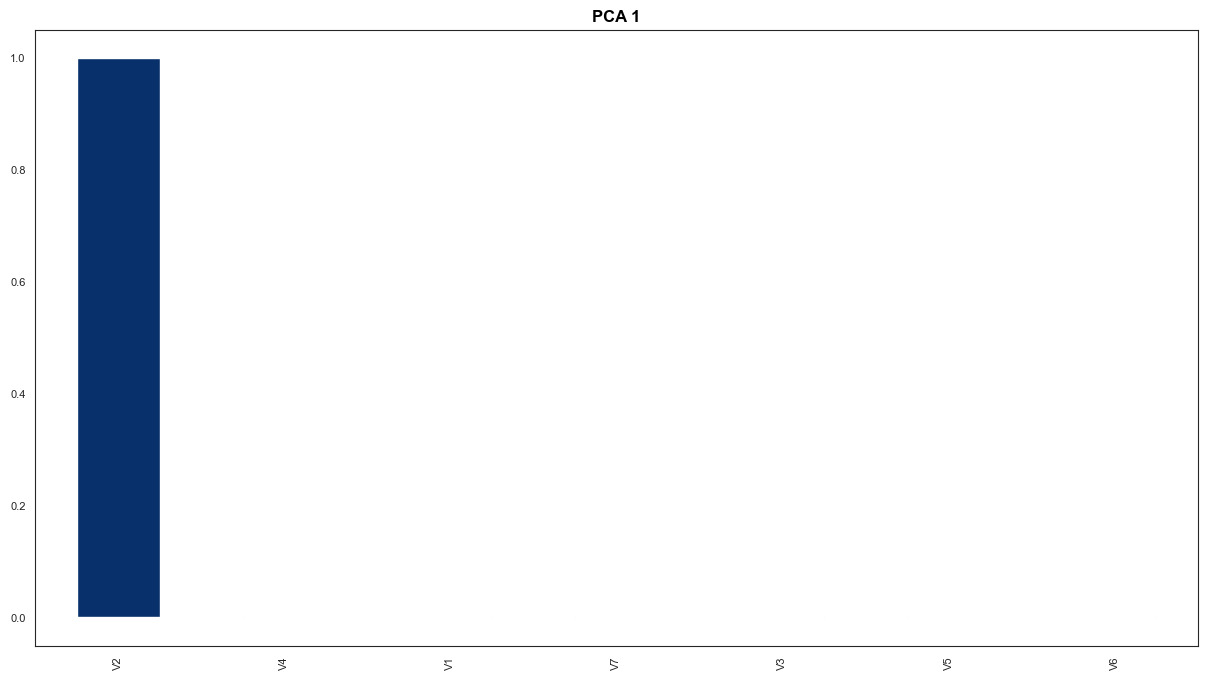

In [346]:
def plot_components(component, df, threshold=0.1):
    df.drop('Explained Variance', axis=1, inplace=True, errors='ignore')
    pca = df.loc[component]
    pca.loc[(pca > threshold) | (pca < -threshold)].sort_values(ascending=False).plot(kind="bar", 
                                                                                      figsize=(15,8), 
                                                                                      title=component,
                                                                                      colormap='Blues_r')
    plt.show()
    
plot_components('PCA 1', pca_results, threshold=-10)                                                          

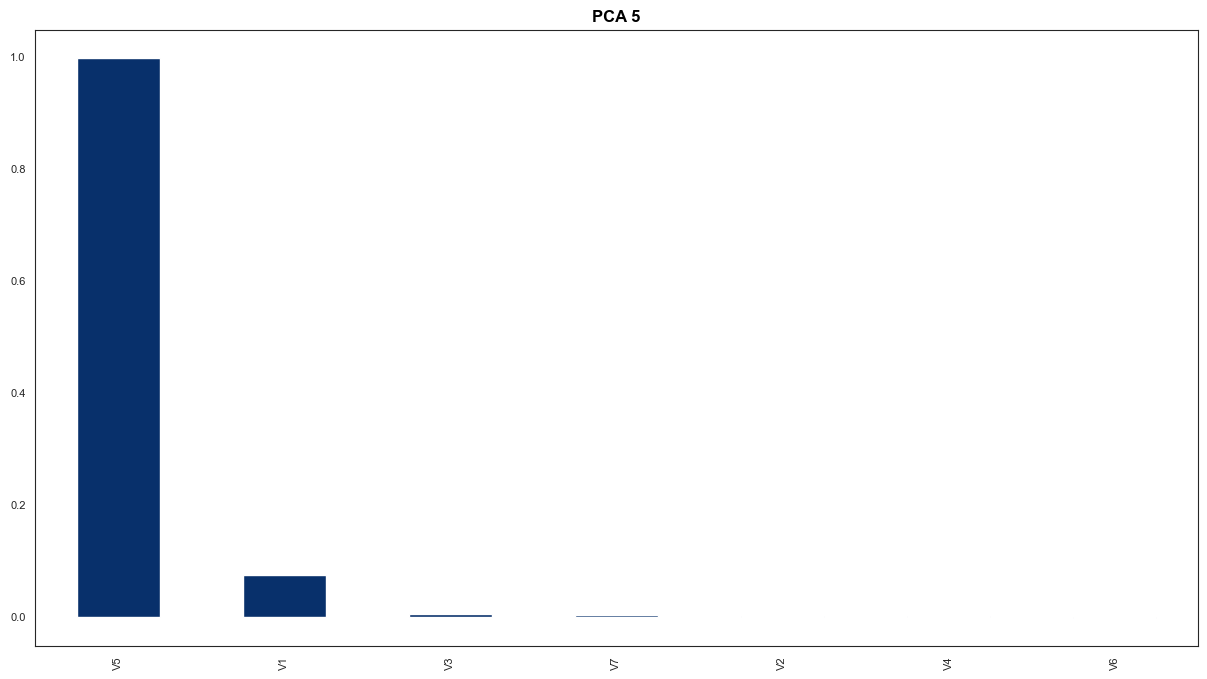

In [431]:
  
plot_components('PCA 5', pca_results, threshold=-10)                                                          

In [362]:
def get_kmeans_score(X, clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=3)
    model = kmeans.fit(X)
    predict = model.predict(X)
    score = np.abs(model.score(X))
    return score


<Figure size 3000x3000 with 0 Axes>

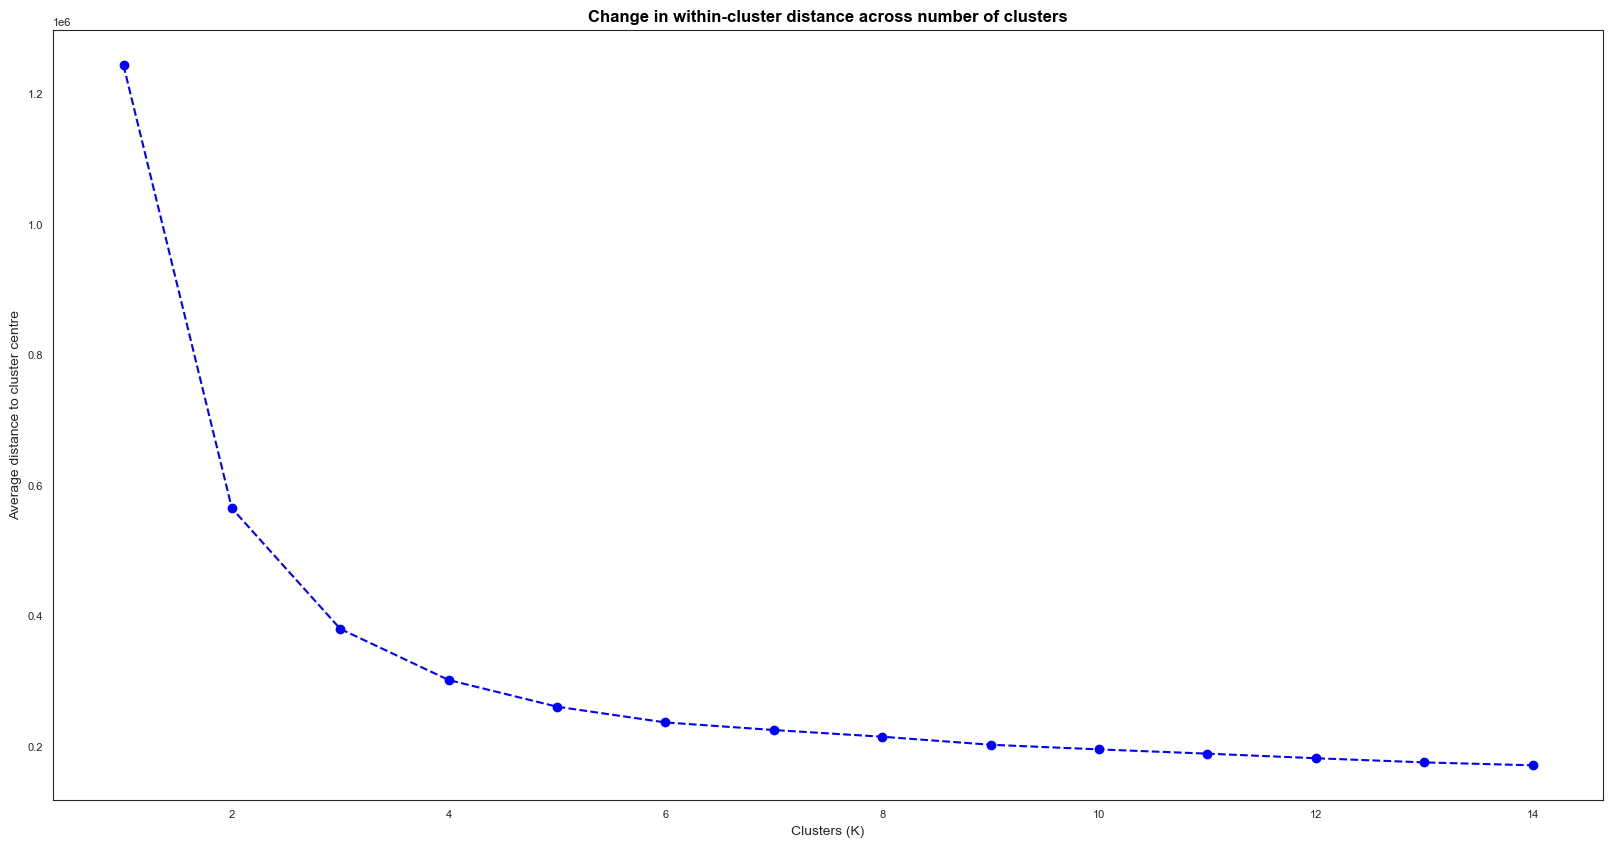

In [363]:
# Over a number of different cluster counts, 
# run k-means clustering on the data and compute the average within-cluster distances
scores = []
clusters = list(range(1,15,1))
for cluster in clusters:
    scores.append(get_kmeans_score(promotion_pca, cluster))
    
# Investigate the change in within-cluster distance across number of clusters.
fig = plt.figure(figsize=(20,10))
plt.plot(clusters, scores, linestyle = '--', marker='o', color = 'b')
plt.xlabel('Clusters (K)')
plt.ylabel('Average distance to cluster centre')
plt.title('Change in within-cluster distance across number of clusters')
plt.show()

In [427]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.mixture import GaussianMixture
kmeans = KMeans(n_clusters=6)
gmm = GaussianMixture(n_components=6,
                      random_state=RANDOM_STATE,
                      covariance_type='diag',
                      init_params='k-means++',
                      )
model = gmm.fit(promotion_pca)
promotion_labels = model.predict(promotion_pca)
df_promotion_labels = pd.DataFrame(promotion_labels,
                                   columns=['cluster'])
df_promotion_labels.value_counts()

cluster
3          13045
5           9557
1           7108
0           6635
2           4535
4           1484
Name: count, dtype: int64

In [428]:
from mpl_toolkits.mplot3d import Axes3D

def plot_clusters(data, labels, label_color_map, title="First three PCA components coloured by cluster",
                  elev=30, azim=-130):
    """
    Plot the first 3 pca components colored by 8 clusters
    
    References:
    https://stackoverflow.com/questions/49564844/3d-pca-in-matplotlib-how-to-add-legend
    https://stackoverflow.com/questions/28227340/kmeans-scatter-plot-plot-different-colors-per-cluster
    """

    fig = plt.figure(figsize=(30, 30))
    ax = Axes3D(fig, elev=elev, azim=azim, auto_add_to_figure=False)

    label_color = [label_color_map[l] for l in labels.cluster]

    # formulate the cluster label that will print inside the diagram. 
    # The label will appear near mean of the cluster
    labelTups = [('Cluster 0', 0), ('Cluster 1', 1), ('Cluster 2', 2), ('Cluster 3', 3),
                 ('Cluster 4', 4), ('Cluster 5', 5), ('Cluster 6', 6), ('Cluster 7', 7)]
    
    # for name, label in labelTups:
    #     ax.text3D(data[labels == label, 0].mean(),
    #               data[labels == label, 1].mean(),
    #               data[labels == label, 2].mean(),
    #               name,
    #               horizontalalignment='center',
    #               bbox=dict(alpha=.7, edgecolor='w', facecolor='w'),
    #               fontsize='xx-large')

    # construct the scatter plot
    ax.scatter(data[:, 0], data[:, 5], data[:, 6],
               c=label_color,
               edgecolor='k',
               s=40,
               alpha=0.6)

    ax.set_title(title, {'fontsize': 40})
    # ax.set_xlabel("PCA 1 - Middle aged - Top earner families", {'fontsize': 30})
    # ax.set_ylabel("PCA 2 - Digital Media kids", {'fontsize': 30})
    # ax.set_zlabel("PCA 3 - Older city lovers", {'fontsize': 30})
    ax.dist = 10

    fig.add_axes(ax)
    
    plt.show()

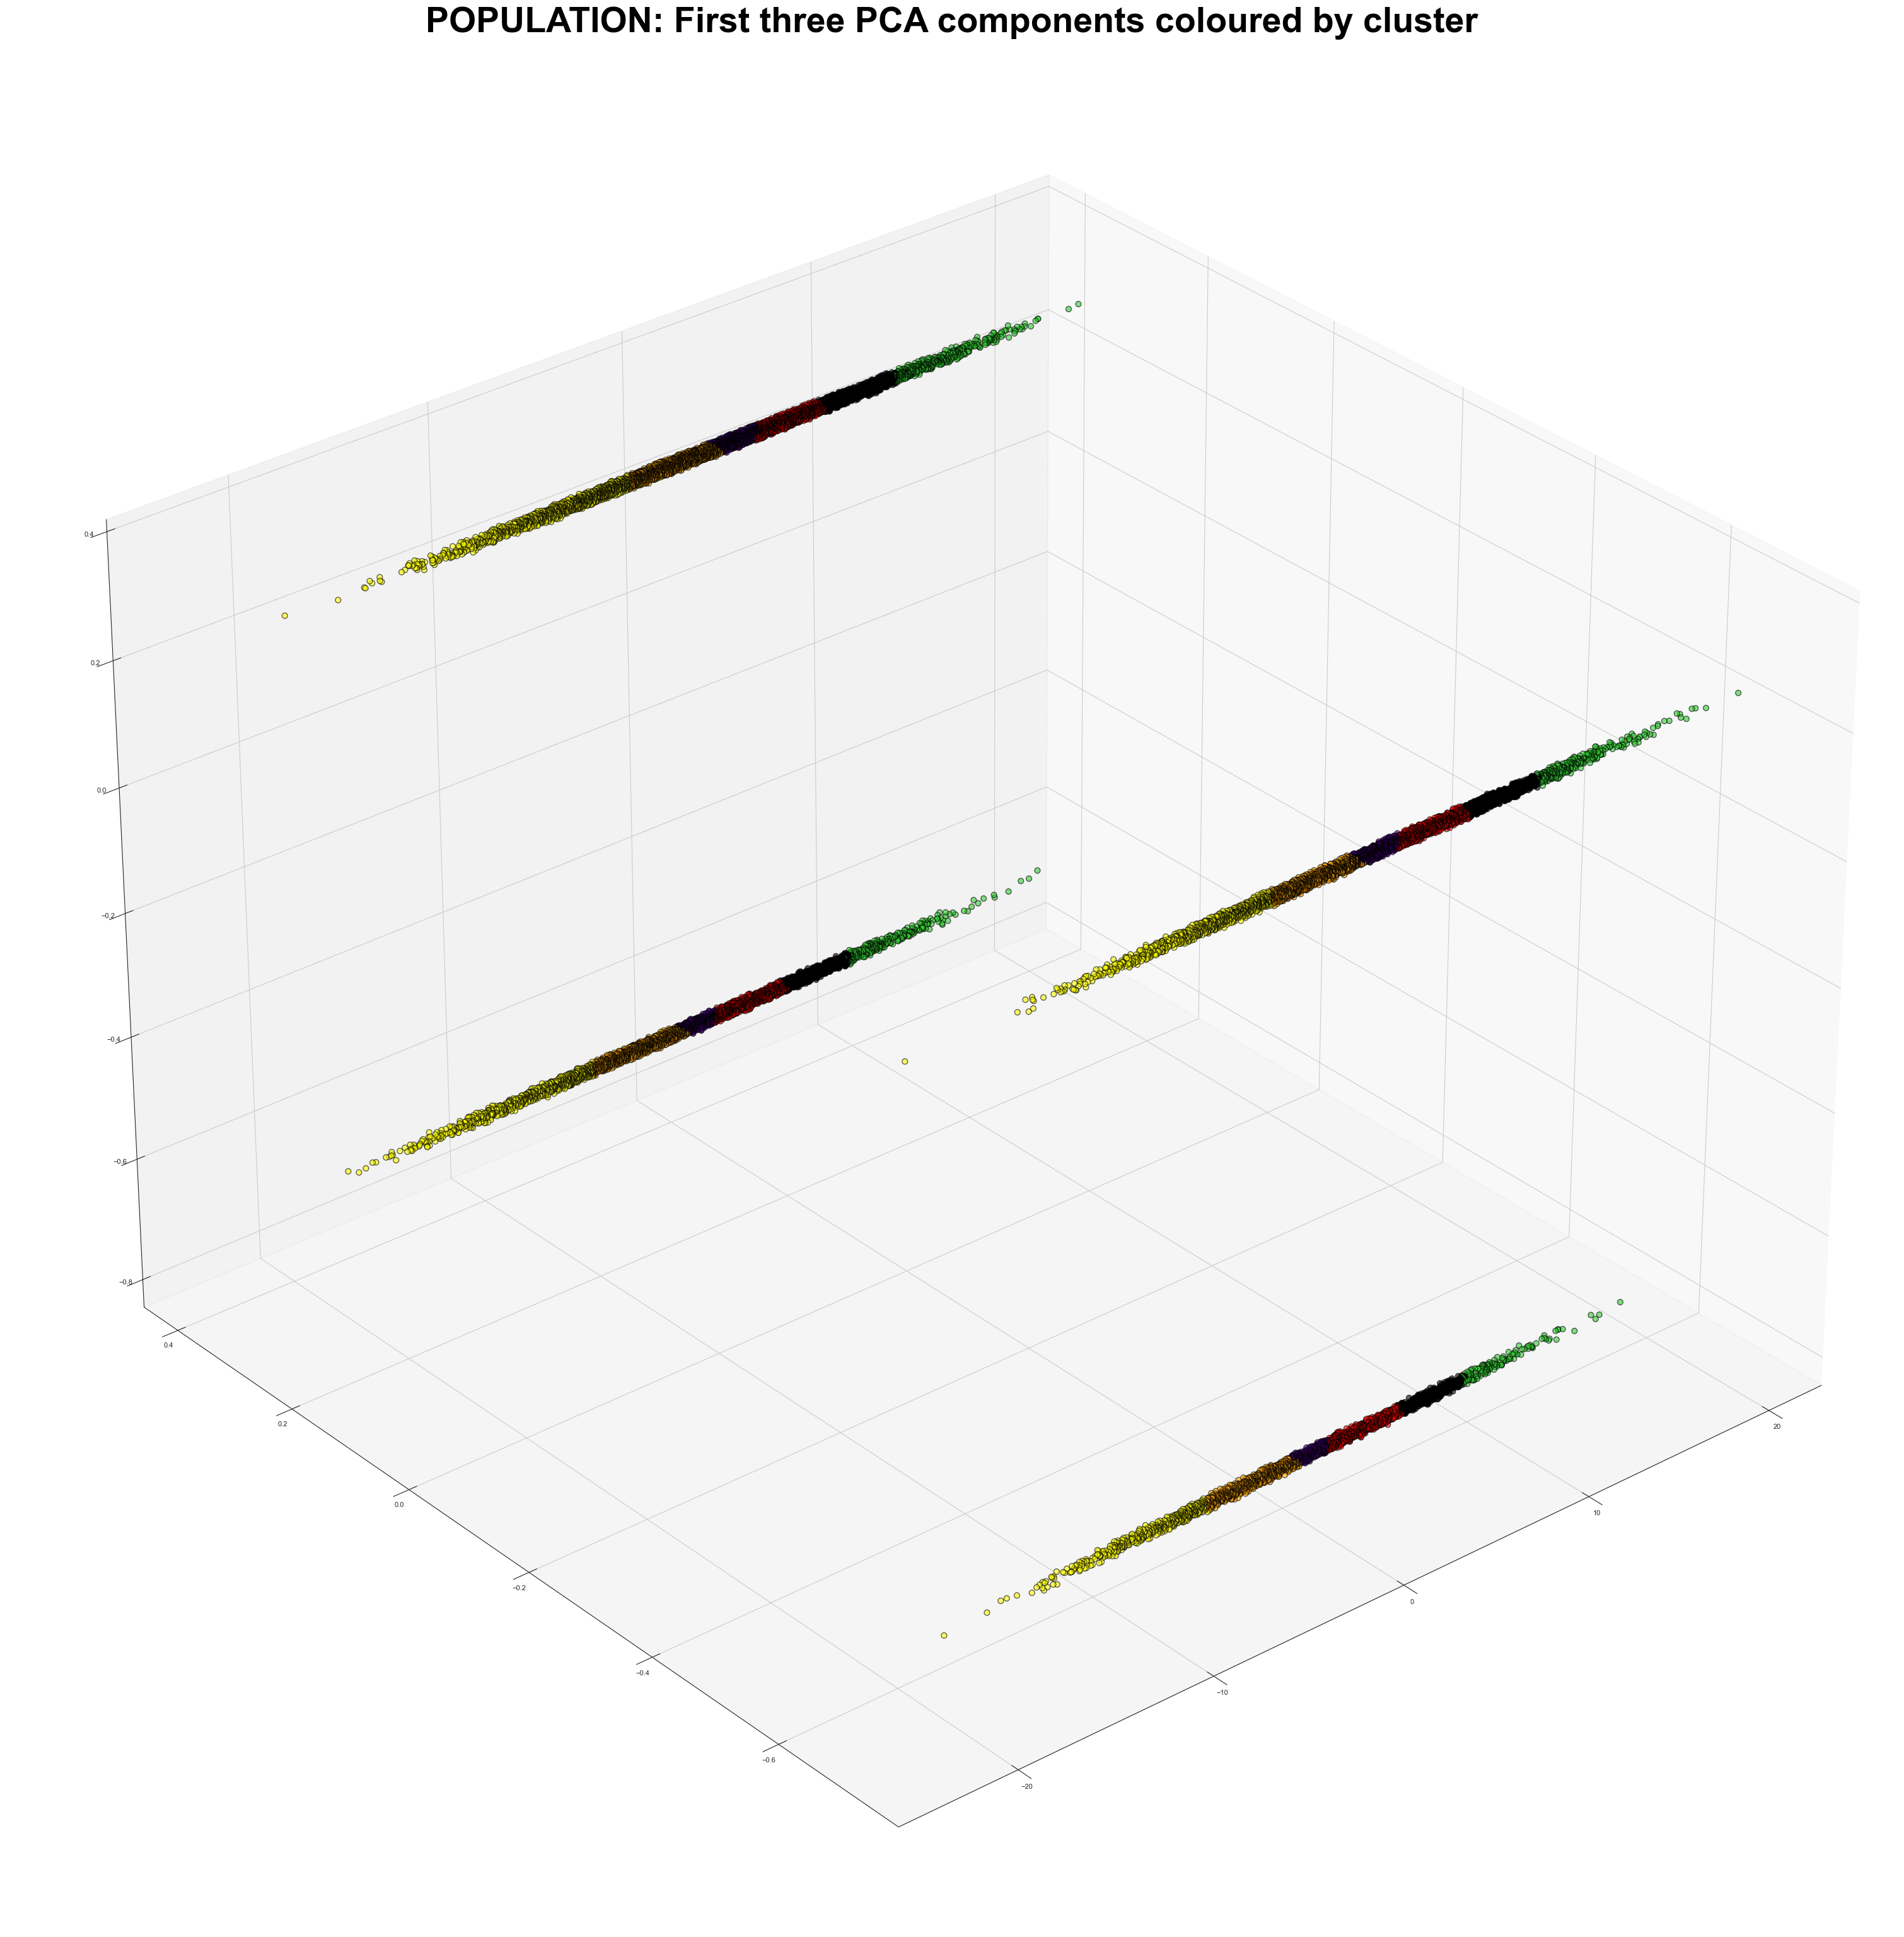

In [429]:
# Plot the first 3 PCA components of the demographic data colored by assigned cluster

label_color_map = {0 : 'indigo',
                   1 : 'yellow',
                   2 : 'black',
                   3 : 'orange',
                   4 : 'limegreen',
                   5 : 'red',
                   6 : 'white',
                   7 : 'pink',
                   }

plot_clusters(promotion_pca, 
              df_promotion_labels, 
              label_color_map, 
              title="POPULATION: First three PCA components coloured by cluster",
              elev=30,
              azim=-130)

# # from another angle
# plot_clusters(promotion_pca, 
#               df_promotion_labels, 
#               label_color_map, 
#               title=None,
#               elev=-50,
#               azim=-130)

In [420]:
df_promotion_labels.head()

,cluster
0,1
1,0
2,0
3,0
4,0


In [ ]:
# What is returned, is for each person (row) in the customer dataset, 
# to which k-means group (1-20) they belong to
no_promotion_labels = model.predict(X_no_promotion)
df_no_promotion_labels = pd.DataFrame(no_promotion_labels, 
                                  columns=['cluster'])

In [ ]:
promotion_proportion = df_promotion_labels.cluster.value_counts(normalize=True, sort=False).sort_index()
no_promotion_proportion = pd.DataFrame(df_no_promotion_labels, columns=['cluster']).cluster.value_counts(normalize=True, sort=False)
proportion_differences = promotion_proportion - no_promotion_proportion


fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

no_promotion_proportion.plot(kind='bar', color='b', ax=axes[0])

promotion_proportion.plot(kind='bar', color='y', ax=axes[1])

axes[0].set_title('Customers who received no promotion')
axes[1].set_title('Customers who received a promotion')

axes[0].set_ylabel('Difference in proportions')
axes[0].set_xlabel('Cluster')

plt.show()

In [ ]:
proportion_differences.plot(kind='bar', 
                            color=np.vectorize({True: 'g', False: 'r'}.get)(proportion_differences > 0), 
                            figsize=(10,8))
plt.xlabel('# of Cluster')
plt.ylabel('Difference if proportions')
plt.title('Difference if Proportions of clusters for full Population and Customer Data')
plt.show()

In [ ]:
X_no_promotion['cluster'] = no_promotion_labels
X_promotion['cluster'] = promotion_labels
X_promotion.head()

In [ ]:
def plot_kmeans_weights_to_pca_relationship(kmeans, cluster, columns, threshold=0.05):
    
    weights = pd.DataFrame(np.round(kmeans.cluster_centers_, 4), columns=columns)
    cluster_weight = weights.iloc[cluster, :]
    title = 'PCA importance for cluster ' + str(cluster)
    cluster_weight.loc[(cluster_weight > threshold) | (cluster_weight < -threshold)].sort_values(ascending=False).plot(kind="bar", 
                                                                                      figsize=(10, 6), 
                                                                                      title=title)

In [ ]:
kmeans.cluster_centers_

In [ ]:
weights = pd.DataFrame(np.round(kmeans.cluster_centers_, 4), columns=list(X_no_promotion.columns[:-1].tolist()))
cluster_weight = weights.iloc[0, :]
cluster_weight.loc[(cluster_weight > threshold) | (cluster_weight < -threshold)].sort_values(ascending=False).plot(kind="bar", 
                                                                                      figsize=(10, 6), 
                                                                                      title=title)

In [ ]:
cluster_no_promotion = X_no_promotion.query('cluster == 0').mean()
cluster_promotion = X_promotion.query('cluster == 0').mean()


fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

sns.barplot(cluster_no_promotion, ax=axes[0])
sns.barplot(cluster_promotion, ax=axes[1])
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

In [ ]:
cluster_weight.loc[(cluster_weight > threshold) | (cluster_weight < -threshold)].sort_values(ascending=False).plot(kind="bar", 
                                                                                      figsize=(10, 6), 
                                                                                      title=title)

In [ ]:
list(X_no_promotion.columns)

## Modeling XGBOOST

In [22]:
class Focal_Binary_Loss:
    '''
    The class of focal loss, allows the users to change the gamma parameter
    '''

    def __init__(self, gamma_indct):
        '''
        :param gamma_indct: The parameter to specify the gamma indicator
        '''
        self.gamma_indct = gamma_indct

    def robust_pow(self, num_base, num_pow):
        # numpy does not permit negative numbers to fractional power
        # use this to perform the power algorithmic

        return np.sign(num_base) * (np.abs(num_base)) ** (num_pow)

    def focal_binary_object(self, pred, dtrain):
        gamma_indct = self.gamma_indct
        # retrieve data from dtrain matrix
        label = dtrain.get_label()
        # compute the prediction with sigmoid (squash values between 0 and 1)
        sigmoid_pred = 1.0 / (1.0 + np.exp(-pred))
        # gradient
        # complex gradient with different parts
        g1 = sigmoid_pred * (1 - sigmoid_pred)
        g2 = label + ((-1) ** label) * sigmoid_pred
        g3 = sigmoid_pred + label - 1
        g4 = 1 - label - ((-1) ** label) * sigmoid_pred
        g5 = label + ((-1) ** label) * sigmoid_pred
        # combine the gradient
        grad = gamma_indct * g3 * self.robust_pow(g2, gamma_indct) * np.log(g4 + 1e-9) + \
               ((-1) ** label) * self.robust_pow(g5, (gamma_indct + 1))
        # combine the gradient parts to get hessian components
        hess_1 = self.robust_pow(g2, gamma_indct) + \
                 gamma_indct * ((-1) ** label) * g3 * self.robust_pow(g2, (gamma_indct - 1))
        hess_2 = ((-1) ** label) * g3 * self.robust_pow(g2, gamma_indct) / g4
        # get the final 2nd order derivative
        hess = ((hess_1 * np.log(g4 + 1e-9) - hess_2) * gamma_indct +
                (gamma_indct + 1) * self.robust_pow(g5, gamma_indct)) * g1

        return grad, hess

In [23]:
class Weight_Binary_Cross_Entropy:
    '''
    The class of binary cross entropy loss, allows the users to change the weight parameter
    '''

    def __init__(self, imbalance_alpha):
        '''
        :param imbalance_alpha: the imbalanced \alpha value for the minority class (label as '1')
        '''
        self.imbalance_alpha = imbalance_alpha

    def weighted_binary_cross_entropy(self, pred, dtrain):
        # assign the value of imbalanced alpha
        imbalance_alpha = self.imbalance_alpha
        # retrieve data from dtrain matrix
        label = dtrain.get_label()
        # compute the prediction with sigmoid
        sigmoid_pred = 1.0 / (1.0 + np.exp(-pred))
        # gradient
        grad = -(imbalance_alpha ** label) * (label - sigmoid_pred)
        hess = (imbalance_alpha ** label) * sigmoid_pred * (1.0 - sigmoid_pred)

        return grad, hess

In [24]:
logger.info('Logging started...')

In [25]:
# train_data_clean['response'] = np.where((train_data_clean['purchase'] == 1) &
#                                         (train_data_clean['Promotion'] == 1), 1, 0)

In [26]:
# train_data_clean['response'].value_counts()

In [27]:
# def weighted_binary_cross_entropy(pred,dtrain,imbalance_alpha=5):
#     logger.info('weighted_binary_cross_entropy started...')
#     # retrieve data from dtrain matrix
#     label = dtrain.get_label()
#     # compute the prediction with sigmoid
#     sigmoid_pred = 1.0 / (1.0 + np.exp(-pred))
#     # gradient
#     grad = -(imbalance_alpha**label)*(label - sigmoid_pred)
#     hess = (imbalance_alpha**label)*sigmoid_pred*(1.0 - sigmoid_pred)
#     
#     return grad, hess


# def focal_binary_object(pred,dtrain,gamma_indct=1.4):
#     logger.info('focal_binary_object...')
#     # retrieve data from dtrain matrix
#     label = dtrain.get_label()
#     # compute the prediction with sigmoid
#     sigmoid_pred = 1.0 / (1.0 + np.exp(-pred))
#     # gradient
#     # complex gradient with different parts
#     grad_first_part = (label+((-1)**label)*sigmoid_pred)**gamma_indct
#     grad_second_part = label - sigmoid_pred
#     grad_third_part = gamma_indct*(1-label-sigmoid_pred)
#     grad_log_part = np.log(1-label-((-1)**label)*sigmoid_pred + + 1e-7)       # add a small number to avoid numerical instability
#     # combine the gradient
#     grad = -grad_first_part*(grad_second_part+grad_third_part*grad_log_part)
#     # combine the gradient parts to get hessian
#     hess_first_term = gamma_indct*(label+((-1)**label)*sigmoid_pred)**(gamma_indct-1)*sigmoid_pred*(1.0 - sigmoid_pred)*(grad_second_part+grad_third_part*grad_log_part)
#     hess_second_term = (-sigmoid_pred*(1.0 - sigmoid_pred)-gamma_indct*sigmoid_pred*(1.0 - sigmoid_pred)*grad_log_part-((1/(1-label-((-1)**label)*sigmoid_pred))*sigmoid_pred*(1.0 - sigmoid_pred)))*grad_first_part
#     # get the final 2nd order derivative
#     hess = -(hess_first_term+hess_second_term)
#     
#     return grad, hess



In [28]:

# class FocalBinaryLoss2:
#     """
#     The class calculates focal loss for multi-label binary classification that contains imbalanced data.
# 
#     This class was inspired by this [kaggle blob](https://www.kaggle.com/code/thedrcat/focal-multilabel-loss-in-pytorch-explained)
#     I changed the coding from a pytorch framework, to use numpy instead to use with XGBOOST
# 
#     The gamma parameter is used to reduce the importance of majority classes,
#     forcing the model to focus more on minority classes.
# 
#     A model trained with focal loss focuses relatively more on minority class patterns. As a result, it performs better.
# 
#     Args:
#         gamma → float: down weighing of majority classes
# 
#     Return:
#         focal_loss → float - average focal loss
#     """
# 
#     def __init__(self, gamma=2):
#         self.gamma = gamma
# 
# 
#     def sigmoid(self, x):
#         """ Calculate sigmoid function """
#         return 1 / (1 + np.exp(-x))
# 
# 
#     def binary_cross_entropy(self, pred, y):
#         """ Calculate binary cross entropy loss """
#         return -(pred.log() * y + (1 - y) * (1 - pred).log()).mean()
# 
# 
#     def focal_binary_cross_entropy(self, predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
#         """ Focal Multilabel Loss
# 
#         The class calculates focal loss for multi-label binary classification that contains imbalanced data.
#         Function was inspired from a pytorch implementation,
#         see [ref here](https://www.kaggle.com/code/thedrcat/focal-multilabel-loss-in-pytorch-explained)
# 
#         The gamma parameter is used to reduce the importance of majority classes,
#         forcing the model to focus more on minority classes.
# 
#         A model trained with focal loss focuses relatively more on minority class patterns.
#         As a result, it performs better.
# 
#         Args:
#             gamma → float: down weighing of majority classes
#             pred: pd.DataFrame: label predictions
#             targets: pd.DataFrame: actual label values
# 
#         Return:
#             focal_loss → float - average focal loss
#         """
# 
#         logger.info('focal loss function entered')
#         # number of classes we try to predict
#         y = dtrain.get_label()
#         num_labels = 2
# 
#         # Flatten the logits and targets so that we can compare two vectors
#         l = preds.reshape(-1)
#         t = y.reshape(-1)
# 
#         # Sigmoid is required when calculating the loss from logits
#         # (meaning it's not probability predictions, but 1 and 0)
#         # We apply sigmoid to the logits to squeeze the values between 0 and 1.
#         p = self.sigmoid(l)
# 
#         # We are following now the standard binary cross entropy with logits loss.
#         # For positive examples, we'll take the sigmoid, for negative examples, we'll take 1-sigmoid.
#         # Good predictions will be close to 1, bad predictions will be close to 0.
#         p = np.where(t >= 0.5, p, 1 - p)
# 
#         # Clamping the input to avoid being to close to zero or one. This is probably for numeric stability.
#         clamp_p = np.clip(p, 1e-4, 1 - 1e-4)
# 
#         # Now we apply the negative log - this is the BCE loss.
#         # This will convert good predictions to a loss that is close to 0, and bad predictions will go to infinity.
#         logp = - np.log(clamp_p)
#         # logp = - np.log(np.clip(p, 1e-4, 1-1e-4))
# 
#         loss = logp * ((1 - p) ** self.gamma)
#         loss = num_labels * loss.mean()
#         print('Focal loss: {}'.format(loss))
#         logger.info('focal loss: {}'.format(loss))
# 
#         return 'focal_loss', loss
    
    # from focalloss import FocalBinaryLoss2

In [99]:
# define scoring methods

# define irr score
def irr_score(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    y_true = dtrain.get_label()
    # logger.info('Actual {}'.format(y_true[:5]))
    
    # Apply sigmoid to the logits to squeeze the values between 0 and 1.
    predt = 1.0 / (1.0 + np.exp(-predt))
    y_pred = np.rint(predt)
    # logger.info('Predicted before conversion: {}'.format(predt[:5]))
    # logger.info('Predicted: {}'.format(y_pred[:5]))
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # logger.info('Confusion results: {}, {}, {}, {}'.format(tn, fp, fn, tp))
    
    if (tp + fp) != 0:
        ratio_promotion = tp / (tp + fp)
    else:
        ratio_promotion = 0
        
    if (fn + tn) != 0:
        ratio_nopromotion = fn / (fn + tn)
    else:
        ratio_nopromotion = 0
        
    # irr = tp / (tp + fp) - fn / (fn + tn)
    irr = ratio_promotion - ratio_nopromotion
    
    # logger.info('IRR: {}'.format(irr))
    return 'irr_score', irr

# scorers = [
#     "auc",
#     "aucpr",
#     # make_scorer(irr_score),
# ]

# define results as a dict
# results = {
#     "scoring": [],
#     "score": [],
#     "irr": [],
#     "nir": [],
#     "n_promotions": [],
#     "n_trials": [],
#     "best_params": [],
# }

# loop scoring methods
# for scorer in scorers:
#     model_tuning(scorer, n_trials=500)

In [432]:
scaler = StandardScaler()
df_ml['V2'] = scaler.fit_transform(df_ml[['V2']])

In [433]:
X = df_ml.drop(['purchase'], axis=1, errors='ignore')
y = df_ml['purchase'].copy(deep=True)
X.shape, y.shape

((42364, 7), (42364,))

In [434]:
X.head()

,V1,V2,V3,V4,V5,V6,V7
4,3,-0.383332,-0.385883,1,1,2,2
8,2,0.390114,0.393317,2,3,1,2
10,1,0.557397,-1.511395,2,1,4,1
12,1,1.390553,0.133583,2,3,1,1
14,3,1.381538,-0.905350,2,2,4,1


In [435]:
# split dataset into train and test datasets
X_train, X_validation, y_train, y_validation = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.20, 
    random_state=RANDOM_STATE
)
# # Split again train into a train and validation dataset
# X_train, X_validation, y_train, y_validation = train_test_split(
#     X_train_val,
#     y_train_val,
#     stratify=y_train_val,
#     test_size=0.20, 
#     random_state=RANDOM_STATE
# )

# resample the minority class
# resample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_STATE)
# smote = SMOTE(k_neighbors=5, random_state=RANDOM_STATE, sampling_strategy='minority')
smenn = SMOTEENN( random_state=RANDOM_STATE)
X_resampled, y_resampled = smenn.fit_resample(X_train, y_train)

# Show the results of the split
print("Training dataset has {} samples.".format(X_train.shape[0]))
print("Validation dataset has {} samples.".format(X_validation.shape[0]))
# print("Test dataset has {} samples.".format(X_test.shape[0]))
print("Resampled Training dataset has {} samples.".format(X_resampled.shape[0]))
print("Resampled Training label dataset has {} samples.".format(y_resampled.shape[0]))

Training dataset has 33891 samples.
Validation dataset has 8473 samples.
Resampled Training dataset has 59941 samples.
Resampled Training label dataset has 59941 samples.


In [436]:
from collections import Counter
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_resampled))

Original dataset shape Counter({0: 33314, 1: 577})
Resampled dataset shape Counter({1: 30525, 0: 29416})


In [442]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7
18483,2,-1.336237,-0.645617,2,3,2,2
23521,3,0.440065,1.345672,2,3,2,1
57106,1,-0.397765,1.345672,2,3,3,2
5509,2,-0.446482,-0.991928,2,3,4,1
15164,0,0.784067,0.393317,1,4,3,2


In [199]:
# scaler = StandardScaler()
# X_resampled['V2'] = scaler.fit_transform(X_resampled[['V2']])
# X_validation['V2'] = scaler.fit_transform(X_validation[['V2']])
# X_train['V2'] = scaler.fit_transform(X_train[['V2']])

# dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtrain = xgb.DMatrix(X_resampled, label=y_resampled, enable_categorical=True)
dval = xgb.DMatrix(X_validation, label=y_validation, enable_categorical=True)
# eval_set = [(X_resampled, y_resampled), (X_validation, y_validation)]
# eval_set = [(X_train, y_train), (X_train, y_train)]

In [455]:
# fw = {'V1':1, 'V2':1, 'V3':3, 'V4':3, 'V5':3, 'V6':1, 'V7':1}
fw =[1, 1, 3, 3, 3, 1, 1]
dtrain.set_info(feature_weights=fw)
dval.set_info(feature_weights=fw)

In [446]:
# focal_loss = FocalBinaryLoss2(gamma=10)
# fl = make_scorer(focal_loss.focal_binary_cross_entropy)

In [447]:
# rmtree(cachedir)

In [448]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
scale_pos_weight

57.73656845753899

In [479]:
# xgb.set_config(verbosity=0)

# cache transformers, so they are only executed once, especially during gridsearch
# cachedir = 'cache'

initial_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': RANDOM_STATE,
    'scale_pos_weight': scale_pos_weight,
    'max_delta_step': 1,
    'booster': 'gbtree',
    'max_depth': 6,
    'colsample_bynode': 0.2,
    # 'tree_method': 'exact',
    'grow_policy': 'lossguide',
}

# # preprocessor 
# categorical_cols = ['V1', 'V4', 'V5', 'V6', 'V7']
# preprocessor = ColumnTransformer(transformers=[
#     # ('one_hot', OneHotEncoder(dtype='int', sparse_output=False), categorical_cols),    
#     ('scaler', StandardScaler(), ['V2']),
# ],
#     verbose_feature_names_out=False,
#     remainder='passthrough',
#     verbose=False,
#     sparse_threshold=0,
#     force_int_remainder_cols=False
# ).set_output(transform='pandas')
# 
# model_base = Pipeline([
#     # ('preprocessor', preprocessor),
#     ('clf', xgb.XGBClassifier(**params, verbose_eval=10, obj=weighted_binary_cross_entropy)),    
# ],
#     # memory=cachedir,
#     verbose=False,
# )

In [480]:
# model_base = xgb.XGBClassifier(**params, verbose_eval=10, obj=weighted_binary_cross_entropy)
# model_base.fit(X_train, y_train, 
#                eval_set=eval_set,
#                verbose=True)
# rmtree(cachedir)

# preds = model_base.predict(X_validation)
# print('AUC: {}'.format(roc_auc_score(y_validation, preds)))
# # pred_labels = np.rint(preds)
# accuracy = accuracy_score(y_validation, preds)
# print('Accuracy: {}'.format(accuracy))

In [486]:
focal_loss_obj = Focal_Binary_Loss(gamma_indct=12)
weighted_loss_obj = Weight_Binary_Cross_Entropy(imbalance_alpha=5)

In [487]:
# # setup parameters for xgboost
# param = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'aucpr',
#     'random_state': RANDOM_STATE,
#     'booster': 'gbtree',
#     'silent': True,
#     "verbosity": 0,
# }
evals = [(dtrain, 'train'), (dval, 'test')]

# def evalerror(preds, dtrain):
#     labels = dtrain.get_label()
#     # return a pair metric_name, result
#     # since preds are margin(before logistic transformation, cutoff at 0)
#     
#     return 'error', float(sum(labels != (preds > 0.0))) / len(labels)




bst = xgb.train(params=initial_params,
                dtrain=dtrain,
                num_boost_round=50,
                evals=evals,
                # obj=weighted_binary_cross_entropy,
                obj=weighted_loss_obj.weighted_binary_cross_entropy,
                # obj=focal_binary_object,
                # obj=focal_loss_obj.focal_binary_object,
                custom_metric = irr_score,
                verbose_eval=30,
                # early_stopping_rounds=50,
                
                )

# get prediction
preds = bst.predict(dval)
print('AUC: {}'.format(roc_auc_score(y_validation, preds)))
pred_labels = np.rint(preds)
accuracy = accuracy_score(y_validation, pred_labels)
print('Accuracy: {}'.format(accuracy))

[0]	train-auc:0.65385	train-irr_score:0.51823	test-auc:0.58907	test-irr_score:0.01387
[30]	train-auc:0.95496	train-irr_score:0.70335	test-auc:0.61969	test-irr_score:0.01575
[49]	train-auc:0.96909	train-irr_score:0.73382	test-auc:0.61858	test-irr_score:0.01338
AUC: 0.6185766598631288
Accuracy: 0.6076950312758173


In [488]:
print(classification_report(y_validation, pred_labels, zero_division=0, output_dict=False))

              precision    recall  f1-score   support

           0       0.99      0.61      0.75      8329
           1       0.03      0.58      0.05       144

    accuracy                           0.61      8473
   macro avg       0.51      0.60      0.40      8473
weighted avg       0.97      0.61      0.74      8473



In [489]:
# print confusion metrix
print('\nConfusion matrix : \n{}'.format(confusion_matrix(y_validation, pred_labels)))


Confusion matrix : 
[[5065 3264]
 [  60   84]]


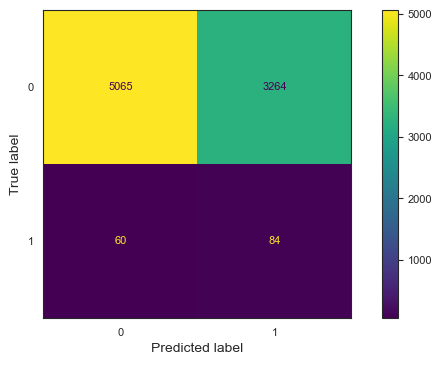

In [490]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_validation, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

## Cross validation with Optuna

xgboost-starbucks-irr - gives 19 profit - v2 too important, without scalling and with v3
xgboost-starbucks-irr_with_v2-scaled_adjusted - so far has best performance over £200, it has not fw

In [263]:
# optuna.delete_study(study_name="xgboost-starbucks-irr_without_v2", storage=storage_name)

In [491]:
# Unique identifier of the study
study_name = "xgboost-starbucks-irr_with_v2-scaled_adjusted_parms2"

# Propagate logs to the root logger
optuna.logging.enable_propagation() 

# Stop showing logs in sys.stderr
optuna.logging.disable_default_handler()

storage_name = 'sqlite:///starbucks.db'

if not os.path.exists(CV_RESULT_DIR_IRR):
    os.makedirs(CV_RESULT_DIR_IRR)
 

In [492]:
def objective(trial, dtrain, dvalid, scoring, initial_params, n_splits=5, random_state=RANDOM_STATE):
    """ Grid search using Bayes Optimization with OPTUNA

    Args:
        trial
        features: pd.DataFrame: pandas dataframe containing features (X_train)
        labels: pd.DataFrame: pandas dataframe containing true labels (y_train)
        model: estimator, creating with sci-kit learn Pipeline
        eval_score: scorer callable object created with sci-kit learn make_scorer
        n_splits: int, number of splits for cross-validation
        random_state: int, random seed for splitting

    Return:
        objective_score: score of a trial
    """

    params = {
        # 'tree_method': trial.suggest_categorical('tree_method', ['exact', 'hist']),
        # 'scale_pos_weight': trial.suggest_int('scale_pos_weight', low=1, high=100, step=1),
        'max_delta_step': trial.suggest_float('max_delta_step', low=1, high=10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', low=0.5, high=1),
        'colsample_bynode': trial.suggest_float('colsample_bytree', low=0.2, high=1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        'min_child_weight': trial.suggest_float('min_child_weight', low=1, high=300),
        'min_data_in_leaf': trial.suggest_float('min_data_in_leaf', low=1, high=10),
        "lambda": trial.suggest_float("lambda", 1e-8, 10), # reg_lambda
        "alpha": trial.suggest_float('alpha', low=1e-8, high=10), # same as reg_alpha
        "max_depth": trial.suggest_int("max_depth", 1, 7),
        "eta": trial.suggest_float("eta", 0.0001, 0.1), # same as learning rate
        "gamma": trial.suggest_float("gamma", 0, 10), # minimum split loss
        # "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }
    
    initial_params.update(params)
        
    # evaluate using the test datasets but avoid doing unnessary trials
    test_eval= 'test-{}'.format(scoring)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, test_eval)
    
    # cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=5, random_state=random_state)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    xgb_cv_results = xgb.cv(
        params=initial_params, 
        dtrain=dtrain,
     #   evals=[(dvalid, "validation")],
        stratified=True, 
        folds=cv,
        num_boost_round=1000, 
        early_stopping_rounds=20,
        metrics = ['auc', 'aucpr'],
        custom_metric=irr_score,
        maximize=True,
        seed=random_state,
        callbacks=[pruning_callback],
        verbose_eval=False,
        shuffle=True,
        obj=weighted_loss_obj.weighted_binary_cross_entropy,
    )
    
    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("n_estimators", len(xgb_cv_results))
    logger.info("n_estimators: {}".format(len(xgb_cv_results)))
    
    # Save cross-validation results
    filepath = os.path.join(CV_RESULT_DIR_IRR, "{}.csv".format(trial.number))
    xgb_cv_results.to_csv(filepath, index=False)
    
    # Extract the best score
    score_name = 'test-' + scoring +'-mean'
    best_score = xgb_cv_results[score_name].values[-1]
    
    return best_score

In [493]:
study = optuna.create_study(sampler=TPESampler(), 
                            direction="maximize", 
                            study_name=study_name,
                            storage=storage_name,
                            load_if_exists=True,
                            )


study.optimize(lambda trial: objective(trial, 
                                       scoring='irr_score',
                                       initial_params=initial_params,
                                       n_splits=5,
                                       random_state=RANDOM_STATE,
                                       dtrain=dtrain,
                                       dvalid=dval), 
               n_trials=200, 
               gc_after_trial=True) 
                        

In [494]:
# import optuna.visualization as vis
# vis.plot_optimization_history(study)
# vis.plot_param_importances(study)
# vis.plot_slice(study)

In [ ]:

def model_tuning(scoring, n_trials=5):
    
    logger.info("START OPTUNA OPTIMIZATION FOR SCORER {} ...".format(scoring))
    
    # Unique identifier of the study
    study_name = "xgboost-starbucks-{}".format(scoring)

    study = optuna.create_study(sampler=TPESampler(), 
                                direction="maximize", 
                                study_name=study_name,
                                storage=storage_name,
                                load_if_exists=True,
                                )


    study.optimize(lambda trial: objective(trial, 
                                           scoring=scoring,
                                           n_splits=3,
                                           initial_params=initial_params,
                                           random_state=RANDOM_STATE,
                                           dtrain=dtrain), 
                   n_trials=n_trials, 
                   gc_after_trial=True) 


    # evaluation results
    best_params = study.best_params
    score = study.best_value
    initial_params.update(best_params)
    print("  Number of estimators for {}: {}".format(scoring, trial.user_attrs["n_estimators"]))

    tuned_model = xgb.train(params=initial_params,
                dtrain=dtrain,
                num_boost_round=trial.user_attrs["n_estimators"],
                evals=evals,
                # eval_metric = scoring,
                # obj=weighted_binary_cross_entropy,
                obj=weighted_loss_obj.weighted_binary_cross_entropy,
                # obj=focal_binary_object,
                # obj=focal_loss_obj.focal_binary_object,
                custom_metric = scoring,
                verbose_eval=False,
                early_stopping_rounds=50,
                )
    
    irr, nir = test_results(promotion_strategy, tuned_model)

    # save each result to results
    results["scoring"].append(scoring)
    results["irr"].append(irr)
    results["nir"].append(nir)
    results["n_trials"].append(trial.user_attrs["n_estimators"])
    results["best_params"].append(best_params)
                        

In [ ]:
for scorer in ['auc', irr_score]:
    model_tuning(scorer, n_trials=5)
results_df = pd.DataFrame(results)
results_df

In [ ]:
filename = CV_RESULT_DIR[2:] + '/3.csv'
results = pd.read_csv(filename)
results

In [174]:
trials = study.get_trials()
trials[136].params

{'scale_pos_weight': 7,
 'max_delta_step': 84.40274695134242,
 'colsample_bytree': 0.9689999912404685,
 'min_child_weight': 24.30509596706012,
 'min_data_in_leaf': 6.547975981872184,
 'lambda': 6.68939742179596,
 'alpha': 37.96447852028903,
 'max_depth': 9,
 'eta': 1.6220688870315652,
 'gamma': 3.1871500265501003}

In [495]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  200
Best trial:
  Value: 0.9519578
  Params: 
    max_delta_step: 7.799133175267282
    colsample_bytree: 0.9524536215964492
    subsample: 0.7675977461661783
    min_child_weight: 1.0020535245681288
    min_data_in_leaf: 7.630515368513778
    lambda: 7.333647199997202
    alpha: 8.315101294517499
    max_depth: 7
    eta: 0.095002287306703
    gamma: 0.007198814876252034


In [496]:
best_params = study.best_params
best_params

{'max_delta_step': 7.799133175267282,
 'colsample_bytree': 0.9524536215964492,
 'subsample': 0.7675977461661783,
 'min_child_weight': 1.0020535245681288,
 'min_data_in_leaf': 7.630515368513778,
 'lambda': 7.333647199997202,
 'alpha': 8.315101294517499,
 'max_depth': 7,
 'eta': 0.095002287306703,
 'gamma': 0.007198814876252034}

In [497]:
print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

  Number of estimators: 1000


In [498]:
# load study results into a dataframe
optuna_study = study.trials_dataframe()
optuna_study.head()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_eta,params_gamma,params_lambda,params_max_delta_step,params_max_depth,params_min_child_weight,params_min_data_in_leaf,params_subsample,user_attrs_n_estimators,state
0,0,0.509251,2024-12-30 14:39:44.585927,2024-12-30 14:39:53.896459,0 days 00:00:09.310532,9.165961,0.520949,0.080706,4.252288,0.044301,6.634852,2,288.610933,3.036327,0.524129,1.0,COMPLETE
1,1,0.786844,2024-12-30 14:39:54.245902,2024-12-30 14:47:13.053633,0 days 00:07:18.807731,1.528536,0.803944,0.072211,4.492156,6.993632,1.182420,3,99.216135,8.259583,0.985343,889.0,COMPLETE
2,2,0.469930,2024-12-30 14:47:13.387763,2024-12-30 14:47:22.263981,0 days 00:00:08.876218,5.900935,0.956068,0.066368,9.993171,1.121648,8.097932,1,126.486605,9.445201,0.840516,1.0,COMPLETE
3,3,0.719256,2024-12-30 14:47:22.577520,2024-12-30 14:54:16.444033,0 days 00:06:53.866513,8.351606,0.785603,0.059686,8.125402,3.760873,2.535829,2,90.022018,9.429183,0.999210,825.0,COMPLETE
4,4,0.761201,2024-12-30 14:54:16.782787,2024-12-30 15:03:08.914086,0 days 00:08:52.131299,6.368084,0.953278,0.085997,9.228538,3.616251,5.675984,3,266.510487,2.220632,0.768783,1000.0,COMPLETE


In [500]:
initial_params.update(best_params)
initial_params

{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'random_state': 88,
 'scale_pos_weight': 57.73656845753899,
 'max_delta_step': 7.799133175267282,
 'booster': 'gbtree',
 'max_depth': 7,
 'colsample_bynode': 0.9726958468153011,
 'grow_policy': 'lossguide',
 'colsample_bytree': 0.9524536215964492,
 'subsample': 0.7675977461661783,
 'min_child_weight': 1.0020535245681288,
 'min_data_in_leaf': 7.630515368513778,
 'lambda': 7.333647199997202,
 'alpha': 8.315101294517499,
 'eta': 0.095002287306703,
 'gamma': 0.007198814876252034}

In [501]:
initial_params.update({"disable_default_eval_metric": True})
initial_params

{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'random_state': 88,
 'scale_pos_weight': 57.73656845753899,
 'max_delta_step': 7.799133175267282,
 'booster': 'gbtree',
 'max_depth': 7,
 'colsample_bynode': 0.9726958468153011,
 'grow_policy': 'lossguide',
 'colsample_bytree': 0.9524536215964492,
 'subsample': 0.7675977461661783,
 'min_child_weight': 1.0020535245681288,
 'min_data_in_leaf': 7.630515368513778,
 'lambda': 7.333647199997202,
 'alpha': 8.315101294517499,
 'eta': 0.095002287306703,
 'gamma': 0.007198814876252034,
 'disable_default_eval_metric': True}

In [512]:
tuned_model = xgb.train(params=initial_params,
                dtrain=dtrain,
                num_boost_round=50,
                evals=evals,
                obj=weighted_loss_obj.weighted_binary_cross_entropy,
                custom_metric = irr_score,
                verbose_eval=5,
                early_stopping_rounds=10,
                )

# get prediction
preds = tuned_model.predict(dval)
print('AUC: {}'.format(roc_auc_score(y_validation, preds)))
pred_labels = np.rint(preds)
accuracy = accuracy_score(y_validation, pred_labels)
print('Accuracy: {}'.format(accuracy))

[0]	train-auc:0.90734	train-irr_score:0.65342	test-auc:0.62797	test-irr_score:0.01440
[5]	train-auc:0.92991	train-irr_score:0.66507	test-auc:0.63869	test-irr_score:0.01521
[9]	train-auc:0.93866	train-irr_score:0.66781	test-auc:0.62990	test-irr_score:0.01579
AUC: 0.62976497778845
Accuracy: 0.49427593532397024


In [513]:
print(classification_report(y_validation, pred_labels, zero_division=0, output_dict=False))

              precision    recall  f1-score   support

           0       0.99      0.49      0.66      8329
           1       0.02      0.74      0.05       144

    accuracy                           0.49      8473
   macro avg       0.51      0.62      0.35      8473
weighted avg       0.97      0.49      0.65      8473



In [514]:
# print confusion metrix
print('\nConfusion matrix : \n{}'.format(confusion_matrix(y_validation, pred_labels)))


Confusion matrix : 
[[4081 4248]
 [  37  107]]


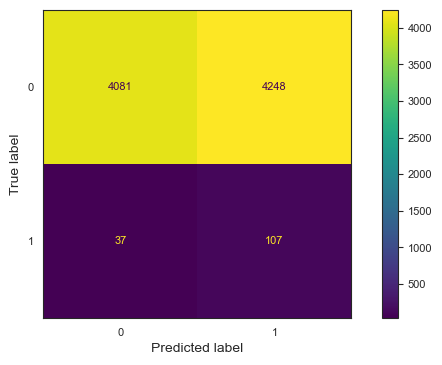

In [515]:

cm = confusion_matrix(y_validation, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

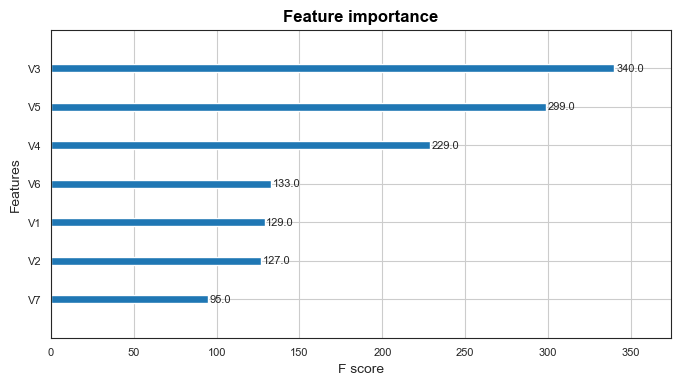

In [516]:
xgb.plot_importance(bst)
plt.show()

## Evaluation

In [509]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should receive a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    # df.drop('V2', axis=1, inplace=True)
    df[cat_cols] = df.loc[:,cat_cols].astype("category")
    dtest = xgb.DMatrix(df, enable_categorical=True)
    preds = tuned_model.predict(dtest)
    promotion = np.where(preds > 0.5, "Yes", "No")
    
    return promotion

In [510]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0184.

Your nir with this strategy is 349.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018409657045541507, 349.0)

https://github.com/handongfeng/Xgboost-With-Imbalance-And-Focal-Loss/blob/master/Xgboost_sklearn.py

https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/notebooks/Machine-Learning-with-XGBoost-solution.ipynb
    
[dynamic bin size](https://medium.com/@maxmarkovvision/optimal-number-of-bins-for-histograms-3d7c48086fde)